#Sentiment Analysis

In [2]:
import pandas as pd
from IPython.display import display, HTML

In [3]:
import torch
print("GPU available:", torch.cuda.is_available())
print("GPU device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


GPU available: True
GPU device: NVIDIA GeForce MX450


In [ ]:
#Import data
# from google.colab import drive
# drive.mount('/content/drive')

# #Define file path and read the file
# file_path = "/content/drive/My Drive/DisneylandReviews.csv"
# df = pd.read_csv(file_path, encoding='ISO-8859-1')
# df.head()

df = pd.read_csv('DisneylandReviews.csv', encoding='ISO-8859-1')
#display(HTML(df.to_html(max_rows=10, max_cols=10)))

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you'll find Disneyland Hong Kong very similar in the layout when you walk into main street! It has a very familiar feel. One of the rides its a Small World is absolutely fabulous and worth doing. The day we visited was fairly hot and relatively busy but the queues moved fairly well.,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,"Its been a while since d last time we visit HK Disneyland .. Yet, this time we only stay in Tomorrowland .. AKA Marvel land!Now they have Iron Man Experience n d Newly open Ant Man n d Wasp!!Ironman .. Great feature n so Exciting, especially d whole scenery of HK (HK central area to Kowloon)!Antman .. Changed by previous Buzz lightyear! More or less d same, but I'm expecting to have something most!!However, my boys like it!!Space Mountain .. Turns into Star Wars!! This 1 is Great!!!For cast members (staffs) .. Felt bit MINUS point from before!!! Just dun feel like its a Disney brand!! Seems more local like Ocean Park or even worst!!They got no SMILING face, but just wanna u to enter n attraction n leave!!Hello this is supposed to be Happiest Place on Earth brand!! But, just really Dont feel it!!Bakery in Main Street now have more attractive delicacies n Disney theme sweets .. These are Good Points!!Last, they also have Starbucks now inside the theme park!!",Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,"Thanks God it wasn t too hot or too humid when I was visiting the park otherwise it would be a big issue (there is not a lot of shade).I have arrived around 10:30am and left at 6pm. Unfortunately I didn t last until evening parade, but 8.5 hours was too much for me.There is plenty to do and everyone will find something interesting for themselves to enjoy.It wasn t extremely busy and the longest time I had to queue for certain attractions was 45 minutes (which is really not that bad).Although I had an amazing time, I felt a bit underwhelmed with choice of rides and attractions. The park itself is quite small (I was really expecting something grand even the main castle which was closed by the way was quite small).The food options are good, few coffee shops (including Starbucks) and plenty of gift shops. There was no issue with toilets as they are everywhere.All together it was a great day out and I really enjoyed it.",Disneyland_HongKong
3,670607911,4,2019-4,Australia,"HK Disneyland is a great compact park. Unfortunately there is quite a bit of maintenance work going on at present so a number of areas are closed off (including the famous castle) If you go midweek, it is not too crowded and certainly no where near as bus as LA Disneyland. We did notice on this visit that prices for food, drinks etc have really gone through the roof so be prepared to pay top dollar for snacks (and avoid the souvenir shops if you can) Regardless, kids will love it.",Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1 hour from Kowlon, my kids like disneyland so much, everything is fine. but its really crowded and hot in Hong Kong",Disneyland_HongKong
...,...,...,...,...,...,...
42651,1765031,5,missing,United Kingdom,i went to disneyland paris in july 03 and thought it was brilliant. i visited all the hotels and stayed in the newport bay and also the kyriad hotels. the newport is a really nice hotel within walking distance of the parks. very big hotel. the kyriad is further away but still a really nice hotel..i saw all rooms at all hotels and they are all pretty much the same. thought the parks were brill and as it was july didn't really have to queue that much i thought. the food was the most expensive thing there. i did the character breakfast which is a must especially if you have young kids and also did buffalo bills which is a really good night. stayed up til late in the nightclub which i didn't think was expe

In [11]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from tqdm import tqdm

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

# Create the sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Apply pipeline (with progress bar for large datasets)
tqdm.pandas()  # Enables progress_apply
df_transformer = df[["Review_Text"]].dropna().copy()
df_transformer["bert_sentiment"] = df_transformer["Review_Text"].progress_apply(
    lambda x: sentiment_pipeline(x, truncation=True)[0]["label"]
)

# Preview results
display(HTML(df_transformer.to_html(max_rows=10, max_cols=10)))


Device set to use cpu
100%|██████████| 42656/42656 [3:29:56<00:00,  3.39it/s]   


,Review_Text,bert_sentiment
0,If you've ever been to Disneyland anywhere you'll find Disneyland Hong Kong very similar in the layout when you walk into main street! It has a very familiar feel. One of the rides its a Small World is absolutely fabulous and worth doing. The day we visited was fairly hot and relatively busy but the queues moved fairly well.,5 stars
1,"Its been a while since d last time we visit HK Disneyland .. Yet, this time we only stay in Tomorrowland .. AKA Marvel land!Now they have Iron Man Experience n d Newly open Ant Man n d Wasp!!Ironman .. Great feature n so Exciting, especially d whole scenery of HK (HK central area to Kowloon)!Antman .. Changed by previous Buzz lightyear! More or less d same, but I'm expecting to have something most!!However, my boys like it!!Space Mountain .. Turns into Star Wars!! This 1 is Great!!!For cast members (staffs) .. Felt bit MINUS point from before!!! Just dun feel like its a Disney brand!! Seems more local like Ocean Park or even worst!!They got no SMILING face, but just wanna u to enter n attraction n leave!!Hello this is supposed to be Happiest Place on Earth brand!! But, just really Dont feel it!!Bakery in Main Street now have more attractive delicacies n Disney theme sweets .. These are Good Points!!Last, they also have Starbucks now inside the theme park!!",4 stars
2,"Thanks God it wasn t too hot or too humid when I was visiting the park otherwise it would be a big issue (there is not a lot of shade).I have arrived around 10:30am and left at 6pm. Unfortunately I didn t last until evening parade, but 8.5 hours was too much for me.There is plenty to do and everyone will find something interesting for themselves to enjoy.It wasn t extremely busy and the longest time I had to queue for certain attractions was 45 minutes (which is really not that bad).Although I had an amazing time, I felt a bit underwhelmed with choice of rides and attractions. The park itself is quite small (I was really expecting something grand even the main castle which was closed by the way was quite small).The food options are good, few coffee shops (including Starbucks) and plenty of gift shops. There was no issue with toilets as they are everywhere.All together it was a great day out and I really enjoyed it.",4 stars
3,"HK Disneyland is a great compact park. Unfortunately there is quite a bit of maintenance work going on at present so a number of areas are closed off (including the famous castle) If you go midweek, it is not too crowded and certainly no where near as bus as LA Disneyland. We did notice on this visit that prices for food, drinks etc have really gone through the roof so be prepared to pay top dollar for snacks (and avoid the souvenir shops if you can) Regardless, kids will love it.",3 stars
4,"the location is not in the city, took around 1 hour from Kowlon, my kids like disneyland so much, everything is fine. but its really crowded and hot in Hong Kong",3 stars
...,...,...
42651,i went to disneyland paris in july 03 and thought it was brilliant. i visited all the hotels and stayed in the newport bay and also the kyriad hotels. the newport is a really nice hotel within walking distance of the parks. very big hotel. the kyriad is further away but still a really nice hotel..i saw all rooms at all hotels and they are all pretty much the same. thought the parks were brill and as it was july didn't really have to queue that much i thought. the food was the most expensive thing there. i did the character breakfast which is a must especially if you have young kids and also did buffalo bills which is a really good night. stayed up til late in the nightclub which i didn't think was expensive at all and it was free entry as we were staying in the disney hotel.. altogether a really good 4 nts that we were there even better that it was all free!!!!!! can't wait to go back,4 stars
42652,"2 adults and 1 child of 11 visited Disneyland Paris beginning of Feb 04 and had an absolute fantastic time.W

In [12]:
df_transformer.to_csv('Labelled_DisneylandReviews.csv', index=False)

##Train classifier on the above data

In [5]:
df_transformer = pd.read_csv("Labelled_DisneylandReviews.csv")

In [3]:
# Count label frequency
label_counts = df_transformer["bert_sentiment"].value_counts().sort_index()

# Calculate percentages
label_percentages = (label_counts / label_counts.sum()) * 100

# Combine into a DataFrame
bert_sentiment_distribution = pd.DataFrame({
    "Count": label_counts,
    "Percentage": label_percentages.round(2)
})

# Display nicely
print(bert_sentiment_distribution)


                Count  Percentage
bert_sentiment                   
1 star           2386        5.59
2 stars          5093       11.94
3 stars          4767       11.18
4 stars         14428       33.82
5 stars         15982       37.47


##Bert Based Uncased

In [ ]:
from sklearn.model_selection import train_test_split
from datasets import Dataset

# Step 1: Create binary label column
df_transformer["risk_label"] = df_transformer["bert_sentiment"].apply(
    lambda x: 1 if x in ["1 star", "2 stars"] else 0
)

# Step 2: Train/test/val split
train_df, temp_df = train_test_split(
    df_transformer, test_size=0.3, stratify=df_transformer["risk_label"], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["risk_label"], random_state=42
)

# Rename columns for Hugging Face
train_ds = Dataset.from_pandas(train_df[["Review_Text", "risk_label"]].rename(
    columns={"Review_Text": "text", "risk_label": "label"}).reset_index(drop=True))
val_ds = Dataset.from_pandas(val_df[["Review_Text", "risk_label"]].rename(
    columns={"Review_Text": "text", "risk_label": "label"}).reset_index(drop=True))
test_ds = Dataset.from_pandas(test_df[["Review_Text", "risk_label"]].rename(
    columns={"Review_Text": "text", "risk_label": "label"}).reset_index(drop=True))

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

c:\Users\tjiay\DSA3101_Group8_Project1\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Map: 100%|██████████| 6399/6399 [00:01<00:00, 3499.75 examples/s]


In [5]:
from transformers import TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

training_args = TrainingArguments(
    output_dir="./bert-high-risk",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    load_best_model_at_end=True,
    weight_decay=0.01,
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds)
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train!
trainer.train()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\tjiay\DSA3101_Group8_Project1\.venv\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\tjiay\AppData\Local\Temp\ipykernel_19108\4060393586.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.200900,0.261963,0.931229,0.780876
2,0.127400,0.234257,0.940919,0.821023
3,0.067300,0.306524,0.941388,0.826469


TrainOutput(global_step=11199, training_loss=0.13954748972386843, metrics={'train_runtime': 19759.3939, 'train_samples_per_second': 4.533, 'train_steps_per_second': 0.567, 'total_flos': 5933016084704256.0, 'train_loss': 0.13954748972386843, 'epoch': 3.0})

In [7]:
trainer.save_model("./saved_distilbert_highrisk_model")
tokenizer.save_pretrained("./saved_distilbert_highrisk_model")

('./saved_distilbert_highrisk_model\\tokenizer_config.json',
 './saved_distilbert_highrisk_model\\special_tokens_map.json',
 './saved_distilbert_highrisk_model\\vocab.txt',
 './saved_distilbert_highrisk_model\\added_tokens.json',
 './saved_distilbert_highrisk_model\\tokenizer.json')

In [6]:
trainer.evaluate(test_ds)

from sklearn.metrics import classification_report

# Get predictions
preds_output = trainer.predict(test_ds)
y_true = preds_output.label_ids
y_pred = np.argmax(preds_output.predictions, axis=1)

# Print detailed report
print(classification_report(y_true, y_pred, target_names=["Not High Risk", "High Risk"]))



               precision    recall  f1-score   support

Not High Risk       0.95      0.98      0.96      5277
    High Risk       0.88      0.75      0.81      1122

     accuracy                           0.94      6399
    macro avg       0.91      0.86      0.89      6399
 weighted avg       0.94      0.94      0.94      6399



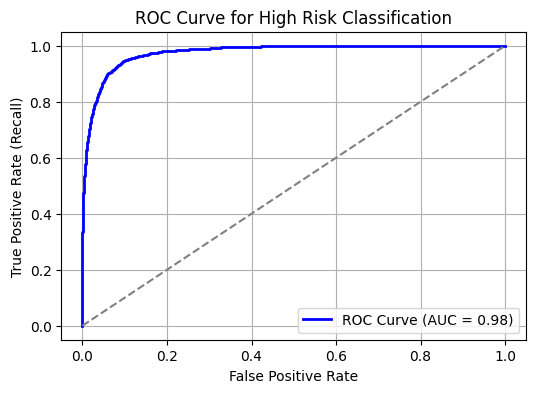

In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get true labels and predicted probabilities for class 1
y_true = preds_output.label_ids
y_score = torch.nn.functional.softmax(torch.tensor(preds_output.predictions), dim=1).numpy()[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve for High Risk Classification")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [9]:
from deep_translator import GoogleTranslator
import pandas as pd
from tqdm import tqdm

# Back-translate from English → French → English
def back_translate(text, intermediate_lang="fr"):
    try:
        # Step 1: English to intermediate
        translated = GoogleTranslator(source='auto', target=intermediate_lang).translate(text)
        # Step 2: Back to English
        back_translated = GoogleTranslator(source=intermediate_lang, target='en').translate(translated)
        return back_translated
    except Exception as e:
        print(f"Translation error: {e}")
        return None

df_high_risk = df_transformer[df_transformer["bert_sentiment"].isin(["1 star", "2 stars"])].copy()
df_high_risk = df_high_risk.dropna(subset=["Review_Text"])  # You can increase later

# Apply with progress bar
tqdm.pandas()
df_high_risk["back_translated_review"] = df_high_risk["Review_Text"].progress_apply(back_translate)

# Preview
df_high_risk[["Review_Text", "back_translated_review", "bert_sentiment"]].head()

  7%|▋         | 546/7479 [18:52<3:52:52,  2.02s/it]

Translation error: Hong Kong Disney Land est le pire Disney que j'ai visité. La superficie totale est si petite que les attractions sont si peu. L'endroit est tellement bondé. La foule y est bruyante et désordonnée. Cet endroit n'a pas du tout de magie Disney. --> No translation was found using the current translator. Try another translator?


  8%|▊         | 592/7479 [20:52<10:08:19,  5.30s/it]

Translation error: Pas aussi bon que publicisé. Vous devez attendre dans une file d'attente pour vous faire cliquer avec les personnages Disney qui peuvent durer des heures. Les manèges sont bien appréciés. Attendu le défilé spécial de Disney mais il a été annulé en raison de la pluie. Dans l'ensemble, pas une bonne expérience. --> No translation was found using the current translator. Try another translator?


  9%|▉         | 674/7479 [23:49<3:46:39,  2.00s/it] 

Translation error: Je pense que j'avais été arnaqué ... Je suis allé à HK Disneyland et j'ai constaté que le trajet en train n'était pas disponible et que le château de Cendrillon était composé de cartes (UpperHalf) mais ils ont toujours facturé le plein prix sur les billets ... --> No translation was found using the current translator. Try another translator?


  9%|▉         | 691/7479 [24:26<3:53:14,  2.06s/it]

Translation error: A réservé une visite de deux jours via KLook.com. Visité le 2 janvier 3. Le 2 janvier avait l'impression que l'ensemble de Hong Kong est allé visiter le complexe. De longues files d'attente partout. Moyenne de 60 minutes Temps de file d'attente pour les manèges. Parfois, atteignant 80 minutes! De longues files d'attente pour les toilettes aussi! Les toilettes féminines ont des files d'attente s'étendant jusqu'à 20 30 mètres dans certaines parties. Le spectacle de Golden Mickey a été une expérience tellement atroce. Showtime était à 18 heures, ils avaient une alimentation dès 16 h 45 et nous ont confiné à une passerelle pendant plus d'une heure. Les toilettes étaient inaccessibles si vous êtes dans la partie intérieure de la file d'attente. J'ai dû sauter par-dessus la balustrade pour aller aux toilettes avec mon enfant de 5 ans. Rien de tel que la priorité pour les personnes enceintes, les personnes handicapées et les familles avec de jeunes enfants (poussettes). Ils

 15%|█▍        | 1110/7479 [40:51<4:02:34,  2.29s/it]

Translation error: I visited HK Disney quite a while ago (Jan 2006). I was thoroughly disappointed but not enough to write a review. However, after reading so many positive reviews, I felt compelled to write one myself.Good   Not crowded; good layout; wide streets; clean; new; cheap compared to other Disneys in every respect   food, merchandise, tickets; landscaping immaculate; convenient to get to; multiple languages for guests.Bad   SIZE; lack of attractions, especially those that make Disney so fun and have made Disney so famous in America; people cutting in lines; people spitting; people sleeping on benches and bathing in drinking fountains; staff being too timid to do anything about obvious rule breakers.Okay, I am from America and grew up near Disney World in Orlando, Florida. I worked in Guangzhou, China for quite a while including the time of HK Disney's opening. Therefore, I was constantly getting news about the new Disney. Because I grew up near Disney World, Disney's definin

 15%|█▌        | 1144/7479 [42:06<3:31:19,  2.00s/it]

Translation error: Nous avions visité Disneyland avec nos enfants en 1989 lorsque California Adventure Park était un parking, donc nous étions impatients d'explorer avec nos petits-enfants en 2019. Nous avons commencé à planifier notre voyage en juillet 2018, nous avons donc passé beaucoup de temps à rechercher les parcs et la région. Très écrasant mais tellement content que nous ayons fait la recherche. J'aurais probablement dû passer plus de temps à rechercher un parking !!! Nous avons acheté des billets de Hopper à 4 jours avec Max Pass, profitant de l'accord de résident canadien bien annoncé et en février 2019, nous avons échappé au vortex polaire en Alberta, au Canada et nous sommes dirigés vers LAX. Le temps était plus frais que prévu, mais notre location de maison et la piscine extérieure chauffée et le bain à remous nous ont toujours réchauffés et un manteau de pluie ou un poncho était emballé. J'avais également roulé ma veste de paquet et l'avais mise dans mon sac à dos. Excel

 18%|█▊        | 1334/7479 [49:25<3:33:28,  2.08s/it]

Translation error: We decided to take our full family on a trip to Disney (mom, dad, adult daughter and her spouse, 19 y.o. & 16 y.o. & 2 dogs!)Best thing about our trip was the kennel at Disneyland. Clean, staff was friendly, and very affordable!All except one of our family has been to Disneyland & California Adventures. We purchased the trip through Costco Travel so I can   t complain one bit about the ticket price and hotel cost. 16 year old is a Type 1 Diabetic and last trip they accommodated this illness splendidly. This go round was an overall disappointment, went to City Hall to see about accommodations and the female staff was polite but more or less said too bad but enjoy your visit with your diabetic. Didn   t expect special treatment but without any accommodations made it difficult to maintain good blood sugar levels when the entire day is spent standing in long lines. We were told that the rest of our party could save a place in line for her if she needed to attend to her s

 18%|█▊        | 1349/7479 [49:58<4:40:12,  2.74s/it]

Translation error: 1. Months beforehand make reservations at Blue Bayou restaurant through Disney internet site. 2. 1 day one park admission is $105 Friday, $115 Saturday, $117 Sunday, and $97 Monday Thursday, the last week of April. 3. Multiday one park admission is $210 for 2 days, $280 for 3 days, and $305 for 4 days, which I got. Once one admission is used, the next 3 admissions must be used in the next 4 days. 4. 3 and 4 day passes come with one Magic morning, where you may enter 1 hour early prior to the 8am or 9am general admission time to Fantasyland or Tomorrowland only. 5. $50 surcharge on the single or multiday passes for a park hopper ticket, where you can enter both Disneyland and California Adventure the same day.6. $10 surcharge per day per ticket for Maxpass ticket. Get fast passes on your cell phone upon availability, without physically going to that fast pass dispenser. 7. Purchase tickets on the Disney internet site, or in person at the box office on the premises. No

 18%|█▊        | 1355/7479 [50:08<3:00:44,  1.77s/it]

Translation error: Cette revue est ce que j'ai appris à faire et à ne pas faire. Par où commencer!?! Ok, laissez-vous commencer avant. Avant d'aller au parc, je lis le blog après le blog sur How to Conquier the Park. Ne fais pas ça !! Quand nous y sommes arrivés, j'étais déjà sur le bord. Prêt à courir comme un poulet avec ma tête coupée pour tirer le meilleur parti du parc. Quand nous sommes arrivés et j'ai vu d'autres adultes courir vers des lignes ouvrir pour entrer et traîner leurs enfants ici et là. Les parents qui se repentent pour que leur enfant puisse vivre des choses. Les parents hurlent sur leurs enfants parce qu'ils ont dépensé tout cet argent, alors ils vont forcer leurs enfants à faire des trajets même si l'enfant pleurait et disait qu'ils avaient peur. M'a brisé le cœur !! J'ai aperçu à quoi j'allais ressembler et je me suis arrêté là et j'ai complètement changé mon plan !! J'ai réalisé que Disney est censé être sur ce que vos enfants veulent faire. Ça ne va nulle part e

 18%|█▊        | 1364/7479 [50:26<3:22:42,  1.99s/it]

Translation error: My husband and I brought our 3 year old son to Disneyland for a family vacation. We would do anything for him, and at the end of the day(s) I think he enjoyed himself and that is really what matters.That said, what a nightmare this experience turned out to be. Happiest place on Earth? More like Hell on Earth. I   m not sure where to begin. The night before we planned to go, we tried to purchase tickets on the app, but received error messages. We ended up calling some customer service number, and purchasing over the phone. We were told to pick up the tickets at will call. When we got to the park we somehow ended up in the line to actually enter the park, even though we were directed to that line as the    pick up ticket    line. When we realized this, my husband jumped out of line to go find the actual ticket booth. At this point, we   d already been waiting in line for quite a while. I tried to find some shade for my son and I to wait in. I guess we were in the way, 

 19%|█▊        | 1389/7479 [51:23<4:34:14,  2.70s/it]

Translation error: Our family travels to Disney parks 2 3 times a year if not more and as a family of 5 this is not an affordable trip however we love Disney so much the expense is worth it! We usually go to Disney World however decided to take a quick trip to Disneyland this year. We purchased 3 day one park tickets for our family. We went to Disneyland park 2 days and California Adventure for one day. Before leaving we find out many rides were shut down as well as part of Main Street, which we had no choice at this point as flights were booked and time had been taken from work. The first day, February 21, we went to Disneyland park we tried to find the days that we could use our magic morning and the employees in the ticket booth were helpful in finding the days but in no way made the experience magical. Usually at park opening the train comes around with characters on it and a family to open the park and on this day the train arrived with no characters and they did a park opening wi

 20%|█▉        | 1478/7479 [54:46<3:19:31,  1.99s/it]

Translation error: Je sais que Disneyland s'appelle l'endroit le plus heureux du monde, mais j'ai été très déçu lors de ma récente visite. Ma petite-fille de 4 ans et sa mère, ma autre fille et moi-même ont tous planifié une première visite surprise à Disney pour ma petite-fille ... Nous avons acheté un laissez-passer d'une journée alors que ma fille et ma petite-fille ont volé de l'État de Washington pendant seulement quelques jours. Nous avons anticipé une journée fantastique, et nous l'avons apprécié, car mes 4 ans ont été excités et aimaient les Rides, avec un favori, car mes 4 ans ont été excités et aimaient les Rides, avec un favori, car mes 4 ans avaient été excités et aimons les Rides, avec un favori, car mes 4 ans avaient été excités et aimaient les Rides, avec un favori, car mes 4 ans ont été excités et aimaient les Rides, avec un favori. Nous étions arrivés tôt pour profiter au maximum de la journée, de 10 h à 22 h ... puis vers 20 h 30, nous avons décidé de monter Peter Pan

 21%|██        | 1555/7479 [57:45<4:11:40,  2.55s/it]

Translation error: Hahaha, title says it all. Ridiculous prices, but do you get what you pay for? Eh, maybe yes, maybe no. I went alone so I could do what I wanted to do. This is the first time I've actually paid to go because usually I get free tickets by winning them or knowing people who work there who need to use their extra tickets, and go with family. Prices are ridiculous, but I knew that before going. This is technically a review for both Disney parks. Cons1) Ticket lines are sooooooooooo slow. There were only a couple of people ahead of me and it took forever for my turn. Then I went up, told the lady exactly what I wanted, had my cash out, and it still took her forever. A snail could have done it faster.2) Walking in the gate with the ticket you just bought is just as slow and painful. They take pictures of you now so if you buy a multi day ticket you can't sell it off to someone else (fine, whatever, I get it) but it just makes the lines horrendously long and slow just to ge

 22%|██▏       | 1649/7479 [1:01:28<3:26:40,  2.13s/it]

Translation error: There are 21,000  reviews of the  Happiest Place on Earth , so I guess that I'll try to keep this one centered around our specific experience to help those folks attempting a similar trip. My wife and I stayed several blocks south of the park with our two children (girl   3 yo, boy   5 yo) and intended to do a 3 day single park pass to Disneyland. And we intended to get our money's worth, so if you   re go getters, this is the review for you.I   ll break the review up by topic: Getting Around, Rides, Events, Characters, Food, and Important Notes at the end.Getting Around:We arrived early on Saturday, dropped our gear at the hotel, and walked the several blocks to Downtown Disney, the shopping plaza between the two parks. We did this mostly to get a reconnaissance of where the entry gates were, and to get familiar with the distance to the park and travel time. Downtown Disney has a fun feel to it, but as my son said, very disappointed, on the walk back to the hotel,  

 28%|██▊       | 2062/7479 [1:17:33<3:44:13,  2.48s/it]

Translation error: RIDES AND CHANGES:I am intensely disappointed that Disneyland has essentially turned Tomorrowland into Star Wars Land.I always loved Space Mountain but I was really really disappointed that it has been turned into a Star Wars ride. I also noticed that Captain Eo is gone. I understand that Disneyland wants to upgrade but there are some things that really should just get a refresher. What they really need to do a full overhaul on is the It's a Small World ride. The upgrades to that ride actually make it more creepy and kind of offensive....oh and by the way, who ever heard of ADVERTISING a company like Siemens in a children's ride?! Come on Disneyland, seriously?! I was also disappointed by the new way they do Fast Passes where I have to wait until after the end time of my current one to get another one; that really is inconvenient when some rides put you many hours out into the future by 10am (like Indiana Jones...we got FPs for that ride at 10:30am and it told us to 

 28%|██▊       | 2131/7479 [1:20:19<3:37:20,  2.44s/it]

Translation error: So the only weekend we could co ordinate a vacation for our high schooler and university student was on Easter weekend and both chose Disneyland as their first choice. I read many warnings that this was the worst weekend for crowds as well as received it from people that it would be awful and we would be turned off Disney forever. I warned my kids who at almost 18 and 20, still love Disney, we did our homework, we sacrificed sleep acquiescing to my husband's militant wakeup schedule and we had the BEST vacation!HOWEVER, this is not a relaxing, fly by the seat of your pants vacation. The people who are unhappy with Disney have not planned well. If you want to sleep, you need to go back to your hotel and have a nap in the middle of the day. To me, Disney is a magical place for children of all ages, but just like throwing your child a good birthday party, it takes planning.Here's some tips:1 First of all, if you want to get the most out of Disney, I cannot stress enough

 31%|███       | 2327/7479 [1:28:10<3:15:41,  2.28s/it]

Translation error: I thought long and hard on my title, and as have yet, not written poor review for anything, let alone terrible. I just can't believe how little customer service there is, how poor the environment and atmosphere is, and that there appears to be no control over the volume of customers (yes customers Disney!!!) who are allowed into the park. That said, my review is not because today (our second day) a Friday, felt so horrendously claustrophobic and inhibiting for our 4 year old that we left after only 2 hours; 1 hour of which was spent queuing for a ride (auto something) that was an archaic pitiful attempt at entertainment, that goes nowhere, does nothing interesting, and ends with disappointed kids, taunted by the prospect of queuing for 80 minutes to get on the Finding Nemo submarine ride. The crowding is so bad it makes you feel very uncomfortable, unable to move anywhere without being pushed or shoved. If you have children who use a buggy (we have 2 kids one of whom

 31%|███▏      | 2342/7479 [1:28:41<2:52:14,  2.01s/it]

Translation error: En tant que visiteur fréquent de Disneyworld en Floride et actionnaire de Disney, j'étais incroyablement excité de voir enfin l'autre côté de la interprétation du pays sur la magie Disney. J'adore Disney, presque au point que vous penseriez que je ne pouvais voir aucun mal à ce sujet. Au lieu de cela, je dois revoir le parc comme terrible, et c'est même après que la mairie a essayé de rendre mon séjour plus magique (ce qui, même cela, a été dit avec dédain par la femme mécontente derrière le comptoir.) Cela a commencé avec une ligne de 40 minutes juste pour se garer, ce qui a coûté quelque chose comme 20 $, et nécessite une marche de 5 minutes avant d'atteindre des tramways, qui a coûté 30 minutes. Ma mère ne peut pas bien marcher, donc ce fut un début frustrant de la journée, mais nous avons pu nous reposer. Nous sommes finalement entrés dans le parc après avoir acheté des sauts de parc coûteux à 9 h 15. Nous sommes allés à California Adventure en premier à cause de

 32%|███▏      | 2377/7479 [1:30:01<3:02:23,  2.14s/it]

Translation error: Let me preface this review with the following information: I have always loved Disneyland with a passion I am a trained medical provider with over 30 years experience I have great sympathy for people who are truly disabled and have volunteered with a local agency that provides guide dogs to the visually impaired. I have raised guide dogs and been a breeder keeper.  I have attended the Disney Institute training required by my employerWe planned this trip to celebrate our anniversary. Decided to go all out and stay on the property for the convenience of being within walking distance of the parks. Also wanted to see the Halloween d  cor and the kids in their costumes as we were there during the trick or treat events (we did not attend, it was an additional fee on top of the passes we purchased, and the park closed at 6pm these nights). As we arrived after the park had opened, stood in line for 45 minutes to enter the park. This was just the beginning of our many  waits 

 32%|███▏      | 2422/7479 [1:31:42<2:55:14,  2.08s/it]

Translation error: J'ai eu des conseils de revue très détaillés pour essayer d'aider vraiment quiconque lira ceci pour maximiser son expérience Disney, mais c'était extrêmement long, donc j'ai été obligé de le condenser. J'ai essayé de garder les détails les plus importants, j'espère que cela vous aidera. Si vous allez investir dans un laissez-passer annuel en utilisant leur système de paiement mensuel, assurez-vous de la réussite que vous souhaitez, car si vous changez d'avis une fois que vous vous êtes engagé à un laissez-passer de niveau spécifique et que vous souhaitez mettre à niveau, vous devez payer la différence à l'avance. Exemple: Si vous vous inscrivez à l'origine à un laissez-passer de luxe et que vous souhaitez plus tard passer à un laissez-passer premium, vous devez payer la différence de 230 $ à l'avance afin de mettre à niveau et vous devez toujours continuer à payer vos versements mensuels convenus. Le personnel des billets de billets n'est pas très bien formé pour exp

 32%|███▏      | 2428/7479 [1:31:55<2:55:47,  2.09s/it]

Translation error: Très bondé même la nuit. Ensuite, ils fermaient simplement un trajet après avoir fait la queue pendant un certain temps. Cela nous est arrivé 5 fois. Disney World est beaucoup mieux. --> No translation was found using the current translator. Try another translator?


 34%|███▍      | 2536/7479 [1:36:20<2:38:32,  1.92s/it]

Translation error: J'ai adoré Disneyland quand j'étais plus jeune et avant d'aller à Big pour eux-mêmes. Était à Disneyland en mai et ne savait pas que le Kelly et Micheal Show enregistraient. Le front entier a bloqué uniquement en poussant les gens à travers rapidement. Occupé avec des gens qui veulent les regarder. Si je savais qu'ils étaient là prévus d'une autre semaine. Nous sommes partis et sommes retournés à California Adventure. Disney déjà occupé alors pour ajouter un enregistrement d'un spectacle au cours du week-end stermère a aggravé. Juste une friandise, ils vous permettent d'apporter des collations et des boissons de l'extérieur. --> No translation was found using the current translator. Try another translator?


 35%|███▍      | 2593/7479 [1:38:28<2:48:42,  2.07s/it]

Translation error: I love Disneyland, always have, even into my adult years. This Disneyland trip was rough    You'll want to read these details, and I hope Disney does too. We enjoyed our trip because our attitudes were right, but Disney tried everyone's patience (and I mean everyone in the park).We went as a family of 6, for my nephews 3rd birthday and his first Disneyland experience (along with his mothers first time). We are from Seattle, so we have no qualms with rain, but we will avoid Disneyland if it supposed to rain. Why? Because the rides don't work! Or at least that seemed to be the number 1 excuse from the employees.Friday, May 15th: rained until maybe 2pm or so, that's fine, people had their ponchos and the lines were short :), but unfortunately every ride we tried to ride was shutting down for various reasons. At first it was Space Mountain (when we asked when it would be up and running again, they said 'don't know, but it breaks down at least 3 times a day'   huh? That i

 38%|███▊      | 2846/7479 [1:47:54<2:55:34,  2.27s/it]

Translation error: I tried very hard to give Disneyland a lower rating, but I just can't do it.We went for 8 days in mid September 2014 with a family of 6: 4 adults and 2 young children. I am not the sort to use the word  magical  lightly: I have travelled a lot and seen a lot of nice things. But Disneyland is still truly magical because of what they do well, which they do better than anyone else.It starts with the staff. I have never had such consistently pleasant and helpful experiences with such a large group of employees anywhere else in the world. They are wonderful people who all genuinely seem to want to be there and they really go out of their way to try to make your experience better. Use them. The  cast members  as they are called helped us so much, from passing on directions and tips on getting into our desired attractions, to answering our questions about all of the many things happening in the park. The staff also go out of their way to help avoid disappointments for the c

 40%|███▉      | 2967/7479 [1:52:23<2:50:57,  2.27s/it]

Translation error: We took our 6 year old son to Disneyland (his first time) expecting it to be a magical experience for us all; unfortunately it was anything but magical. We planned and paid for our June trip in January, unaware that June 17 19 was the worst possible time to go. Upon our arrival the first day, we noticed an inordinate number of people...the lines to the rides were 45 minutes to over an hour, although the posted  wait time  was often only 5, 15, or 20 minutes. After the first 2 rides, we asked a Disney  cast member  about the long wait times and seriously large crowd, and she explained to us that this was due to the  day pass  holders trying to get in their last visit(s) before the passes expired...and she added that it would be better for us to come back but not on the 19th because that was  senior day  when all the 2014 grads would be there and it would be even worse. But, we were from out of town and had hotel rooms only through the 19th, so we were stuck. Since we 

 41%|████▏     | 3097/7479 [1:57:18<2:24:15,  1.98s/it]

Translation error: Si vous n'êtes jamais allé à Disneyland, vous vous demandez quoi apporter, où séjourner, comment tout faire! Je vais juste donner des conseils qui nous ont aidés à passer une bonne journée. Nous sommes toujours partis totalement épuisés, mais c'est vraiment inévitable. Vous êtes heureux, mais définitivement épuisé. Si vous avez des enfants, vous devez décider à l'avance quand et combien vous dépensez sur des jouets (bibelots), il y a des charrettes avec des rotations, des jouets brillants et de nombreux ballons impressionnants, des barbecues en coton, des sucettes, de la crème glacée, etc. Tous les quelques pieds et à l'extérieur de la plupart des promenades, vous passerez à travers un magasin entier déposé avec des jouets à partir de leurs films préférés. Terriblement tentant !!! Nous avons dit à notre enfant de 5 ans qu'il pouvait choisir quelque chose le dernier jour. Une fois qu'il a connu l'accord, il n'a pas demandé toutes les 10 minutes qui peuvent porter tout

 42%|████▏     | 3137/7479 [1:58:54<2:09:37,  1.79s/it]

Translation error: Went to Disneyland the first weekend in January of 2014, and it is simply not what it used to be. I remember when it used to be about family entertainment, and now more and more the it shows that it is a corporate structure that shamelessly cares only about money and not about making the experience a happy one. It was really crowded, though I have been in worse. It should not be a place to go, where you have to think:  Is today going to be a really bad day, or will I be lucky for a change and not have to wait 45 minutes just to get in the front gate?  For a family of 4 (with 2 under nine) just your gate is going to cost you a significant amount of money ($356 1  day one park; $536 one day hopper; $674 2 day one day for each park). And, you have not paid to park, or for any food or lodging. Perhaps it would be nice if you did not have to wait in so many lines. First of the day the tram or the bus. Then, wait to pass through security. Then, wait to buy a ticket. Then, 

 42%|████▏     | 3175/7479 [2:00:18<2:33:42,  2.14s/it]

Translation error: As my boyfriend and myself were out to venture a wonderful day at our favorite beloved location, we were terribly disappointed. It was about noon as we had started to develop an appetite so i decided to call The Thunder Barbecue Ranch Restaurant and make a reservation. I had looked up the phone number online and called and had a nice conversation with the cast member. I had asked if it was All You Can Eat as I could recall from my last visit years ago, and she replied, Yes, Its $10 per person. She had explained to me the possibility of a cancellation fee and had asked for my card number to set the reservation on. I cheerfully explained to her that my boyfriend and my self were happy to find this place for its cheap price and our extremely small budget considering that we're college freshmen around Christmas time, shopping for our families soon. Our budget for food for the entire day was $20. So around our reservation time, we had arrived and sat at a table. We receiv

 43%|████▎     | 3183/7479 [2:00:31<2:15:55,  1.90s/it]

Translation error: If it was possible to rate them a zero I would have. While I realise that Disneyland and Disney   s California Adventure are two separate parks they much of what I have to say applies to both parks. There is not enough information out their about either park for first time visitors. They cram to many people into to smaller space and charge way to much for it. It seems that the only way that Disneyland is value for money is if you live in California, pay monthly for an annual pass and spend most of your free time there. For staff that are responsible for moving a lot of people all the time, their crowd control is terrible. It seems to me that they have given responsibility to people who are to young and inexperienced, resulting in people who are on a power trip telling people what to do and where to go that is not conducive to getting anyone anywhere in a timely and efficient manner. The scheduling of things within the parks also seems to be an issue. For instance the

 43%|████▎     | 3222/7479 [2:01:58<2:35:23,  2.19s/it]

Translation error: We were a bit disappointed by our Disneyland experience because the cutting of so many corners seems to have been a bit too obvious this trip. We visited between 9 30 and 10 3, four day park hopper tickets. Here is my list of grips with Disney that I wish they'd work on for future visitors. 1. Got a call from guest services two days before my long drive down the coast to tell me that I should have been able to purchase convention tickets after all, although their website clearly stated those were not valid until 10 2. The gentleman also told me that the  3rd party  tickets I purchased from aRes Travel would NOT be redeemable at the hotel check in desk. (He was incorrect on both counts, and his phone calls was clearly a sales pitch full of ignorance or deception). I was not impressed. I made several calls to Disney to find out why the $1,000 I spent on tickets was now being called fraud, and they wouldn't guarantee to redeem the ticket vouchers. You can imagine the st

 44%|████▎     | 3260/7479 [2:03:22<2:44:02,  2.33s/it]

Translation error: Too many things to do for just a one day visit. I   ll focus less on the what to do at Disney and more on how to get the most out of your visit. We travel from Canada every few years for a few days of Disney. I   ve been back a dozen times or so over the years. I recommend getting a multi day park pass. Especially one that has a    Magic Morning    on it. A Magic Morning pass gets you into the park one hour earlier than the general public and Tomorrow and Fantasyland are the only parts of the park that are open. Im under the impression if you stay at one of the Disney resorts you get multiple magic mornings, so that might be a valuable consideration. Or get a Southern California pass (buy it from Universal Studios, use it there 1st and you get two days Universal Studios admission instead of just one if you buy it elsewhere). Southern California pass has a 3 Day Disney admission   one Magic Morning, 1 Day At Universal Studios (or 2 day, see above), 1 Day Sea World. Pa

 46%|████▌     | 3445/7479 [2:10:21<2:04:10,  1.85s/it]

Translation error: J'ai eu une expérience très désagréable pendant que je visitais Disneyland Resort, Anaheim, le 31 décembre 2012, oui, c'était le réveillon du Nouvel An, et c'était vers 23h30 quand j'essayais de prendre le compte à rebours du Nouvel An et les feux d'artifice à Disneyland (à partir de 22h00 à 23h20, j'étais dans le parc d'aventure en Californie pour voir le World of Color Show). Je voudrais partager mon expérience avec vous et j'espère qu'il y aura une amélioration de la procédure de Disneyland pour les laissez-passer de plusieurs jours.J'ai eu un billet de 5 jours de parc de parc et je suis entré correctement Disneyland, j'ai présenté mon billet et mon identifiant photo pour la dame nommée Isabella (si je me souviens bien) Disneyland pour noter mon nom sur le billet le premier jour de ma visite, après cela, j'ai continué à utiliser mon billet, l'encre s'estompe seule, rien que je ne pouvais faire à ce sujet. Elle a insisté pour dire que le stylo était la marque perma

 47%|████▋     | 3537/7479 [2:13:52<2:18:31,  2.11s/it]

Translation error: You know, I just can   t help it. I have to be unbiased and truthful, even when it pertains to Mickey Mouse. Disneyland is NOT the happiest place in the world.It is the happiest place in the universe!With so many fantastic recent updates and changes, there is still that special something that can not be described    a feeling that can not be duplicated    when walking below the plaque that reads    Here you leave today and enter the world of yesterday, tomorrow, and fantasy   . And it   s true, isn   t it? Try to walk around Disneyland and think about your bills, or the report that is due on Monday. I bet you a churro that you can   t do it!A day at a Disney theme park is one of the few things about today   s society that I can honestly and truthfully say that I believe is worth the money. In this economy, quite a few families may be thinking about visiting less frequently, but in my opinion, cut back on take out. For after all, can one really put a price tag on magi

 49%|████▉     | 3696/7479 [2:20:05<2:27:18,  2.34s/it]

Translation error: First off, I'd like to address all of the people who are giving Disneyland California Adventure negative reviews. Based off of the reviews given by unhappy Disney consumers, I have concluded that most are upset about a few main points: A) Disneyland is crowded, B) Disneyland is  expensive  and D) There was some other factor that was unrelated to Disney that made your trip not enjoyable. I have come up with some explanations about why these critics believe this way about Disneyland. First, I will address the  Disneyland is expensive  issue. One day park hopper tickets to Disneyland and California adventure cost $80.00. This ticket includes admission into BOTH parks, all day, usually from 8 AM until Midnight. A one day (single park) ticket to Six Flags costs approximately $70.00 for hours that are about 10:30 AM to 8 PM. I'm not saying that the two are comparable (Obviously Disneyland is a way better deal) But when you consider everything that you're getting, it's clea

 52%|█████▏    | 3893/7479 [2:27:37<2:38:25,  2.65s/it]

Translation error: Never in a million years did I think I would like Disneyland more than Disney World. After 5 spectacular trips to Disney World in the last 9 years, I had significant doubts about my decision to travel to Disneyland. I was convinced that nothing could trump my love for the Magic Kingdom; but, boy was I wrong!We had purchased the special deal that afforded us 5 days in the park for the price of 3; however, we only had 4 full days and 5 nights to spend. So, our first view of the park occurred around 7:00 PM in the evening (with closing time being at midnight). When we arrived, I was not the least bit impressed by the Entrance Plaza, nor was I enthused with the Train Station. And, when we walked down Main Street, the only thing I could concentrate on was the wimpy castle. I was completely underwhelmed and almost in tears. I tried not to show my disappointment, but I sincerely wished that I could click my heals and be transported to Orlando.That first evening, we had 7:30

 53%|█████▎    | 3935/7479 [2:29:23<2:22:01,  2.40s/it]

Translation error: I just returned yesterday from a 5 night stay in Anaheim, CA visiting Disneyland and California Adventure. We stayed from Feb 19   23, 2008. We were fortunate enough to have an Uncle in LAPD and he was nice enough to get us 3 day hopper passes for $56 each. Which is an incredible deal since one day, one park passes are $66.Unfortunately the second day my ticket got taken away. All of the other members of our family were able to get in fine (everyone got their name on their ticket) but unfortunately mine got messed up, and instead of my name it had our Uncle's name. The first day I had no trouble coming going from Disneyland, but the second day when we entered for our Plaza Inn breakfast a very rude CM took it away without explanation and made me wait 20 minutes for his manager to explain to me what the mix up was.After the manager (who wasn't much nicer) told me they were taking my ticket away, and finally gave back my ID. I had to buy one day passes at $66 for the n

 53%|█████▎    | 3958/7479 [2:30:20<2:05:20,  2.14s/it]

Translation error: Nous avons visité Disneyland lors de la célébration du 50e anniversaire et pour moi, c'était très décevant. Nous avons visité le 20 février 22. Nous avons acheté les Hoppers de 3 jours Parker afin que nous puissions visiter Disneyland et California Adventure. Ce fut la première visite de mes filles qui, à 7e et 4 ans, étaient très excitées à l'idée de visiter Disney. Nous avons sorti 7 ans de l'école pendant quelques jours et nous avons pensé que février serait le bon moment pour visiter et nous pourrions éviter les foules énormes qui convergent sur Disney pendant les mois d'été. Eh bien, nous avions tort. Il semble qu'il n'y ait pas un très bon moment pour visiter et éviter les foules énormes. Notre premier jour était un lundi et c'était des vacances, donc nous nous attendions à ce qu'ils soient bondés depuis que l'école était sortie. Les mardi et mercredi suivants n'étaient pas meilleurs. Il semble que beaucoup d'autres personnes aient la même idée. Les seules fois

 53%|█████▎    | 3963/7479 [2:30:33<2:35:23,  2.65s/it]

Translation error: We were at Disneyland on Friday 4 8 and at California Adventure on Saturday 4 9. We got in at 10:30 and there was about a 5 minute wait to go thru the bag inspection tables and another 5 to go thru the turnstiles. A friend of ours already bought us the SoCal 2fer tickets and so we didn't have to line up for tickets. By the way, we are not from SoCal but our friend was. Apparently they only check IDs when they sell the tix but not at the turnstiles because we got in without anyone checking to see if anyone in our group was from SoCal. By the time we got in, the park was teeming with people already. I had planned to go to the Winnie the Pooh ride first thing, but a character sighting derailed that plan. Because of our late entry and judging from my son's reaction to the park so far (it was our first time at the park) I realized I had to ditch my well researched plan (I researched many internet sites and more than a couple of guide books for this trip) and just  go with

 54%|█████▍    | 4076/7479 [2:34:58<1:57:55,  2.08s/it]

Translation error: C'était ma 8e visite à Disneyland Paris, le premier étant lors de son ouverture. J'ai séjourné dans les hôtels Disney et aussi ceux à proximité. Je suis allé à Disneyland Paris deux fois pour Noël et je l'ai vraiment apprécié les deux fois. Ne vous méprenez pas, c'est toujours un bon parc mais commence à montrer son âge. «Grubby» me vient à l'esprit. Partout, il semble que cela pourrait faire avec un bon nettoyage et un smurvey. Les murs et les plinthes dans les restaurants sont éraflés et ont de grandes jonques qui y sont éliminées. La peinture s'écaille dans de nombreux domaines. Je suis allé à Walt Disney World 9 fois et à Disneyland California 3 fois. Tous ces parcs sont impeccables. DLP semble pouvoir faire avec un équipage qui le traverse et le faire nettoyer à nouveau. Tout a un film vert dessus depuis les conditions humides et froides. Nous sommes allés sur le vapeur à palette et les élans en plastique sur la rive de la rivière avaient même le moule vert sur 

 55%|█████▍    | 4079/7479 [2:35:06<2:12:03,  2.33s/it]

Translation error: Soo disappointed in my experience. :( I will preface this review by saying I am a HUGE Disney fan. Coming from the States as a frequent traveler to Walt Disney World and Disneyland in Anaheim, CA, I understand that the bar is set VERY high for Disney parks and attractions. When I first arrived to central Paris, our driver asked what we were doing. When I said our stay concluded with the New Years Eve party and stay onsite in Disneyland Paris, he told me that it was a shame because the parks in the USA are so much better and there are so many things to see and do in France. I laughed it off, but I now realize that he was 100% right. I had done 0 research beforehand as I had gone to Disneyland and Disney Studios several years ago, but my memory is vague. If I recall though, the Studios Park was a bit more fun. If you have a limited time in Paris and if you   ve been to other Disney parks, I   d recommend skipping this one. It does NOT compare to the parks in the states

 55%|█████▌    | 4136/7479 [2:37:27<1:56:32,  2.09s/it]

Translation error: C'était donc début octobre, le temps commençait à passer de tropical à froid, sombre et déprimant. Nous avons eu un excellent été et pour nous éloigner des météo Blues, ma femme et moi avons décidé de faire un voyage à Disneyland Paris pour les vacances à mi-parcours pour enfants vers la dernière semaine d'octobre. Ce qui est intéressant, c'est que nous avons décidé de faire un road trip en Europe pendant toute la semaine au dos de cette idée. Je n'entrerai pas dans les détails de l'autre partie du voyage et je me concentrerai sur Disneyland lui-même. Je m'excuse! J'adore raconter une histoire! Plus de critiques à venir pour les autres parties du voyage. Les prix étaient raisonnables pour les billets de parc 2 jours 2 (450 pour 2 adultes et 2 enfants âgés de 5 et 6 ans). Nous y avons conduit et sommes restés dans un appartement à proximité (je vais le passer en revue séparément). Les premières impressions étaient bonnes. Le parc est bien entretenu par les navettes de

 58%|█████▊    | 4329/7479 [2:45:31<1:51:28,  2.12s/it]

Translation error: Since many years I read a lot about this place in Paris but mainly negative news through newspapers, forums and one of the US colleagues, thus I didn   t have great hopes visiting this place.But my wife had clean slate about this place and she wanted to visit    The Happiest Place on Earth    & after 2 days we did have happiest time on earth Here are tons of tips to make your trip memorable    There are 2 parks which you can visit in 2 days namely Disneyland Park ( 10:00     23:30 ) & Walt Disney Studios ( 10:00     19:00 )     1 day is NOT enough to cover both parks, you will miss many interesting rides. We recommend minimum 2 days    As you   re spending good amount of money for park, stretch a bit more to enjoy 2nd day as well.    After validating ticket, do NOT forget to pick up 2 pamplates namely Park Layout Plan & Programme Plan    Most annoying thing for me was waiting for ride for 45 minutes and it gets over in 30 sec to 2 minutes     We   ve created 6 catego

 59%|█████▊    | 4392/7479 [2:48:04<2:16:03,  2.64s/it]

Translation error: Hi allHaving just returned from DLP I thought it might be useful to write a short idiots guide with some of the info I wish I'd known before I went.Firstly   getting there. We drove (going through the chunnel) so if you're flying we can't help you with this bit. Our Satnav got us there no problem and most people will have some form of access to a satnav these days. There are signs to DLP but they are few and far between so don't rely on them to guide you there. There is also a very good guide that we used to get us there. It's here under post number 9: https:  www.tripadvisor.co.uk ShowTopic g226865 i2224 k5776128 Driving to DLP and advise please Marne la Vallee Seine et Marne Ile de France.htmlBe aware of the advice about 3 4 of the way down where you need to be in the fast lane to get to the right road   this is easy to miss and the French tend to drive nose to tail so changing lanes can be traumatic! There are guides to avoiding the toll on the A1 but, given what 

 60%|█████▉    | 4466/7479 [2:51:05<1:41:53,  2.03s/it]

Translation error: Fitulations d'une heure: pour la majorité des manèges, il y a eu une longue file d'attente (parfois encore plus).   Pour vos clients qui ne restent à Disneyland que pendant un jour ou deux, c'est un gros problème car cela signifie que nous avons moins de temps pour profiter pleinement de Disneyland. FastPass: C'est particulièrement frustrant lorsqu'il est pratiquement impossible d'utiliser le FastPass. Vous deviez arriver à la balade que vous vouliez d'abord pour réserver tout à l'avance plutôt que de simplement faire la queue dans la voie Fastpass comme vous le feriez dans n'importe quel autre parc à thème (pourquoi iriez-vous à un tour, puis repartez et reviendriez-vous?). Bien qu'il soit apparu très tôt, toutes les manèges ont été réservés trop rapidement au moment où nous les sommes arrivés, nous n'avons donc pas pu l'utiliser même une fois! Des heures magiques et des difficultés techniques: les points ci-dessus ont à peu près ruiné notre premier jour à Disneylan

 62%|██████▏   | 4654/7479 [2:58:45<1:46:37,  2.26s/it]

Translation error: Disneyland World   a place that is world renowned for delivering plenty of Disney fun. So how does its European equivalent in the land of liberty, equality and fraternity compare to the original in the land of opportunity? A recent visit enabled an interesting comparison, and the score card is not promising:1. Disneyland park and rides: how did my favourite rides match up to their counterparts in the U.S.? Not easy to ascertain... pirates of the Caribbean   closed for repair; A small world : closed for refurbishment ; space mountain (or rather their exciting new ride Hyperspace Mountain)   sounded promising given the screaming going on while we were waiting in the queue, however the ride broke down for the 2nd time that day 20 mins into our wait   so we were told to come back later.... At least the Haunted Manor did not disappoint (and was open, which was a bonus). 3 out of 4 of our favourite rides open   strike 1.2. Fastpass    Board within a matter of minutes  is h

 64%|██████▍   | 4771/7479 [3:03:41<1:49:18,  2.42s/it]

Translation error: Je n'avais jamais été aussi excité d'aller à Disneyland pour la première fois, mais notre expérience était quelque peu différente de la façon dont j'imaginais. Le parc est beau et enchanteur, c'est vrai, mais la disposition est déroutante et les files d'attente sont ridicules. Bien sûr, c'est ce que nous attendions d'avoir visité Disneyworld Orlando, mais par rapport à là-bas, Disneyland ne le coupe tout simplement pas. Nous avons fait la queue pendant 3 heures au Princess Pavilion, pas tout à fait sûr de ce qu'il était réellement, nous avons pensé que cela devait être quelque chose d'incroyable pour toute cette traction et cette file d'attente. Mais non, c'était une rencontre avec une princesse qui a pris les 30 secondes, nous avons été tellement déçus que nous avions perdu tant de temps à attendre (bien que cela nous ait pris hors de la pluie!). Nous avons rejoint plusieurs files d'attente pour les personnages pour signer le livre d'autographes et obtenir une photo

 67%|██████▋   | 5042/7479 [3:14:09<1:35:16,  2.35s/it]

Translation error: I was recently made redundant from my job of 15 years. I have 2 daughters aged 24 and 21 and we are huge Disney fans. We have visited Orlando on a few occasions when they were younger. I decided that I would use some of my redundancy money to fund a Disney trip as a treat. I could not afford Orlando so we booked a trip to Disneyland Paris and the three of us were very excited about it. The trip was a catastrophic disappointment. We stayed at the New York Hotel which was lovely   no real complaints there. We were offered the free meal plan which I upgraded to the Plus Plan.We arrived on Tuesday 28th June quite late and decided we would go into Disney Village for our evening meal. We decided to use our vouchers at Annette's. Whilst the food was lovely the service was unacceptable. We were served by a young waiter who advised us what we could order from the menu. I explained that I am vegetarian and so he said I could have the Veggie Burger, I asked if if was possible t

 71%|███████   | 5292/7479 [3:23:49<1:24:46,  2.33s/it]

Translation error: Where do I even begin? I joined this site specifically to write this review. And Ive been thinking of what to write throughout the holiday. We went in half term, 15 19 feb 16. This was our second visit as a Family. We went last March but in term time and loved it, but felt we didnt get everything done so booked it again. We stayed in the hotel Cheyenne.To make this review make more sense, I need to say last year we loved it. It was amazing and we hadnt stopped thinking of going back since. Almost everyday it crossed my mind. Also we have two Children, at the time of the most recent visit the boys 3 almost 4, the girls 7 almost 8. Disneyland Paris is an unusual place and very hard to make a review of. There were times this week where I could have given it a 1 star rating, and times where 5 stars wouldnt be enough. Our first day there, Monday was ok, we got a lot done. it became apparent how busy it was compared to last year by the huge amount of people watching the pa

 72%|███████▏  | 5370/7479 [3:26:48<1:31:00,  2.59s/it]

Translation error: Let   s just imagine for a minute the meeting with senior Disney executives and the agenda is to decide where to locate the European Disney Resort. Old Uncle Walt would have already chain smoked himself into Forest Lawn Memorial Park so it was left to some numbnut to suggest Paris as an appropriate location.Of course, as well all know there   s nothing whatsoever wrong with Paris, France with the exception of two key things: the traffic is the first and secondly, France is filled with French people. If you go to Disney Paris, be aware that you will very soon come into contact with both.Now, in 2015, you have driven several hours, the latter two covering around half a mile, to reach your Hotel destination to be assured by a fabulous French hurrah for all your efforts and the promise of the best time of your life.If you now drive up to the gate of the Newport Bay Club Hotel you will be confronted with another two things     scaffolding and a large security guard. You w

 73%|███████▎  | 5435/7479 [3:29:20<1:22:18,  2.42s/it]

Translation error: My husband and I travelled to Euro Disney (as they called it then back in 2006'.Compared to back in 2006 it seems to have gone a little downhill sadly ... Or maybe we were spoilt with a trip to Florida in 2007 who knows.We decided to travel to Disneyland Paris as it was closest, easiest and cheapest for our two children (2 years and 6 years). We stayed at the Kyriad hotel which suited nicely as it wasn't too far away and offered free shuttles to and from Disney each day.Upon arriving at Disneyland (which was a complete surprise for our children) it was sadly pouring with rain. Being English we are used to the odd downpour but we did fancy a Poncho and so we queued for almost 30 minutes at a small booth for a poncho for us and the kids . We found the ques appalling! People were shoving and shouting and quite frankly my husband looked totally bewildered by the idea of having to push and shove for a bit of plastic and he is too polite to push and be rude, thus it took u

 74%|███████▍  | 5544/7479 [3:33:28<1:09:14,  2.15s/it]

Translation error: It's going to be difficult to write this review without sounding obnoxious. Basically, if you've never been to Walt Disney World in Florida and you enjoy theme parks or are a Disney fan, then go ahead and don't read my observations below   jump in with both feet and you'll probably have a wonderful time. I would say 'try to avoid school holidays', but being a teacher myself and having school age children I get extremely irked when I read that advice in other reviews, so just grab the opportunity to go when you can. I'd recommend May half term rather than August, due to crowds and heat.If, however, you have been to Orlando and, like us, cannot afford to go again but are feeling the need for a hit of Disney, this review might be worth your while reading   especially if you had the time of your life in Florida, and more particularly if you are likely to end up spending a third of what the Florida fortnight cost you on a 4 day break at Disneyland Paris. In short, and in 

 75%|███████▌  | 5621/7479 [3:36:24<58:28,  1.89s/it]  

Translation error: Just back from a family trip to EuroDisney Paris. It was everything I feared it would be ... but far worse! To sum up my experience in three words: Queues, queues, queues.The bad. The weather was unbearably hot, 100F, not Disney's fault I know this would not have been nearly as bad if it wasn't for all the time required to be outdoors queuing. I would never go again in summer. Food overpriced. Merchandise overpriced. Not enough picnic and play areas. Kids got bored and tetchy with queues. The good   the staff were all very friendly and well trained whilst doing a very stressful job with stressed customers. Felt safe on rides. The other guests were also very polite despite the sufferance. Shame that smoking was allowed in the park. I know outdoors but why should I have to breath in other peoples filth whilst standing in queues and watching parades? Parade good. Park buildings and landscaping lovely.Monday. I arrived by packed shuttle bus which was full to bursting and

 76%|███████▌  | 5668/7479 [3:38:11<1:10:35,  2.34s/it]

Translation error: So if you've done the USA Disney thing then you'll find this Park smaller and similar. If you have not then you'll find it large and amazing.The Park itself has all the usual Disney magic you'd expect (unlike the Disney Studios Park). However its not operating the Fastpass  system so still stuck with the ticket booth system for fast passes and many of these didn't work or were closed. The park had a strange lack of Characters and zero photo spot photographers so don't waste your money on a memory maker or photopass card as there's nobody to get your photo with and nowhere to have one taken by a cast member like in the USA despite these being sold! Also the ride photos don't all work. The flora and fauna is decent but not a patch on the USA version. The food is the same format but with a French take on USA cooking. This is a bit hit and miss. Amazingly the French couldn't cook a steak to save their life here and the size of the steaks was anything but in line with the

 76%|███████▌  | 5680/7479 [3:38:39<1:13:34,  2.45s/it]

Translation error: I have been to Disneyland Paris quite a few times. The first time was in 1992 when it first opened.Back in '92 It was expensive but well organised and the staff in general were polite and helpful. They had a happy and friendly disposition which you would expect from a theme park.I am sad to say that the original park has deteriorated and in need of a make over. The restaurants and rides are generally unresourced which makes the whole experience painful.You would for example not expect there to be long queues just to get into a restaurant. We pre booked all of our restaurants but still had to queue to get in. A 1:00 pm reservation turned out to be an actual 1:35 get into the restaurant followed by slow service. This was more a staffing issue (presumably to save money)I was also disappointed by the number of rides being refurbished. When you pay   50 00 to get in to a park, you expect to see all of it, not 85%. but at least they are refurbishing the place as it does lo

 76%|███████▌  | 5695/7479 [3:39:12<57:10,  1.92s/it]  

Translation error: Moi-même et ma femme avons visité Euro Disney pour ses célébrations tardives du 50e anniversaire. Nous avons séjourné à l'hôtel Magic Circus Off Site de 23 5 à 26 5. Nous avons eu un laissez-passer de 2 jours pour les parcs pour 24 5 et 25 5. Saturday 24 5 transformé en probablement le pire jour de notre vie. Nous sommes arrivés au parc à 10h45 et avons été accueillis à une mêlée de 15 minutes et 1000 personnes pour obtenir la sécurité dans le site. Une fois que nous l'avons atteint, nous avons obtenu nos billets. Comme j'avais la prévoyance de préserver cela, nous avons réussi ce peu rapidement et sans tracas. Une fois dans le parc, nous nous sommes dirigés vers l'arrière car c'était le quartier le plus calme. Après une file d'attente de 15 minutes pour monter sur le petit tour du monde, nous avons ensuite réussi à monter sur Casey Junior et un voyage de conte de fées. Il était maintenant à midi et le parc se soulevait avec des gens. Nous avons décidé d'aller sur le

 76%|███████▌  | 5701/7479 [3:39:25<1:02:11,  2.10s/it]

Translation error: Ayant été à Disneyworld Orlando quatre fois avec mes enfants il y a de nombreuses années, cette expérience m'a donné une vie de souvenirs. Cette année, en mai 2015, j'ai décidé avec ma femme d'emmener ma petite-fille à Disneyland Paris. Je suis allé pendant six jours, cinq nuits et j'ai payé le forfait alimentaire Premium en plein conseil. J'ai séjourné à l'hôtel New York dans la station. L'hôtel était OK mais attendait plus pour un hôtel quatre étoiles. J'ai malheureusement eu un vol précoce et je suis arrivé à la station à 1020 heures du matin. On m'a dit sur l'enregistrement que la pièce n'était pas prête avant 15 heures. Pas bon quand vous avez un enfant de quatre ans qui se lève et voyage depuis 4 heures du matin. Dans la plupart des hôtels d'Europe, les chambres sont généralement disponibles au milieu de la journée. J'ai remarqué que les carreaux dans la salle de bain étaient fissurés le long du fond par le sol et que les lits étaient comme dormir sur des palet

 78%|███████▊  | 5848/7479 [3:45:11<42:10,  1.55s/it]  

Translation error: Tout d'abord, j'ai été déçu. J'adore les parcs Disney, ayant été à Disneyland en Californie à plusieurs reprises et WDW en FL, plusieurs fois, j'ai été surpris par mon propre niveau de déception. Je suis dans le service client de Disney, le thème, les attractions et la nourriture. Je suis fan! Cela dit, Disneyland Paris n'a pas répondu à mes attentes dans le service à la clientèle ou l'entretien. Il semblait délabré dans de nombreux domaines, il n'était pas organisé, en termes de manque de files d'attente pour les personnages, de timing pour les spectacles et les défilés (20 minutes en retard, deux fois). Les personnages avaient l'air un peu minables, comme s'ils mettront la main des costumes de personnages de WDW. Si vous n'êtes jamais allé à WDW, ce parc peut sembler acceptable pour un correctif Disney, mais si vous avez visité Disney Parks aux États-Unis, vous serez déçu. Alors que ma famille et moi nous sommes amusés dans ce parc, si nous devions, nous en ferions

 78%|███████▊  | 5850/7479 [3:45:16<52:40,  1.94s/it]

Translation error: We've stayed here a few years ago and had a much better experience then. I remember eurodisney being the hight of customer service, with everyone in staff adding to the  magical  experience, from the janitor to the reception and the characters.Now, staff looks tired and run down. Characters were nice to our daughter (4) when they were in their role, but ignored her when she spotted them walking to their destination. No explaining to a child why  King Louis  was obviously ignoring her (quiet area, she was yelling and pleading, he's her favorite Disney character). It was little things like this that just made the experience less  childhood dream  and more  mcDonalds . Housecleaning in the hotel threw her teddy bear onto our bed (he was face down with arms and legs mixed up). For a children's destination, I would expect them to tuck him in or at least put him nicely on her bed. It's a small amount of energy that makes all the difference. I know it sounds nit picky... I 

 80%|████████  | 5996/7479 [3:50:57<39:22,  1.59s/it]  

Translation error: Cet endroit est horrible, aucun autre mot pour cela, des prix exorbitants, une valeur horrible, une terrible fourniture de nourriture, une organisation générale pauvre, oui, les enfants l'adorent, mais ils ne le voient pas pour les problèmes pratiques qu'il apporte. Notre visite avec le stationnement coûte 243 pour une journée dans deux parcs, plus de 12 heures dans les 2 parcs et 8 randonnées plus tard 30 par trajet, je ne me plaignerai jamais sur les funfairs britanniques. La file d'attente pendant 40 70 minutes pour la plupart des manèges, lorsque le travail ou entièrement opérationnel est inacceptable, nous avons attendu 30 minutes pour un trajet, il a ensuite brisé, nous avons persisté 15 minutes supplémentaires puis l'avons abandonnée. Chaque trajet sur lequel nous avons fait un wagon ou un obstacle similaire à être pleinement opérationnel. Le personnel, bien que généralement serviable et bilingue, n'a pas utilisé beaucoup de hâte pour maintenir les choses en m

 81%|████████▏ | 6080/7479 [3:54:14<52:34,  2.25s/it]  

Translation error: I don't really know where to start with my story of Disney land Paris. Their is the fairy tale view that you have the moment you walk in the park, the first thing you see is sleeping beauty's in front of you, your child face lights up, I am afraid it slowly goes down hill from their and you need to hide your, upset and stress from your innocent children. I was crying on the last day as the strain of what I had paid for and the reality finally hit me, it was the worst holiday I had ever had in my life and for   1500 to start with for 3 days 2 nights I am devastated.I will bullet for the problems as much as I can to inform people of the problems, not just my emotional response to the park as this would be my view and not everyone's. People all view things differently, what one finds except able the other may not, which is why I will list factual problems and some of the pros.PROSDisney express luggage is fantastic, you can not cope with out this. You take your luggage 

 82%|████████▏ | 6169/7479 [3:57:36<49:04,  2.25s/it]  

Translation error: Just returned from my eleventh trip to DLP with hubby, son (8) and daughter (almost 5) and missing it already. There were a few negative points this time but overall we all loved it and had a fab time! We cannot recommend DLP more, especially to those who are Disney fans or have children who are. It is a truly magical experience for little ones.We had a 4 night stay in the Sequoia Lodge Hotel. We chose this hotel this time as stayed there previously and know it to be a 'cosy' and 'comfy' hotel, plus we knew it had been recently refurbished so wanted to check that out! Had a Montana Room, decor in Bambi style which was lovely...had that classic Disney touch. Rooms a little on the smallish side (we have stayed in the New York last couple of times and had forgot that rooms there are a little larger) but we were comfortable. As seasoned pro's we remembered our teabags, coffee, travel kettle etc. because there are NO TEA MAKING FACILITIES IN ROOM! If you, like us, like yo

 83%|████████▎ | 6216/7479 [3:59:26<44:37,  2.12s/it]  

Translation error: Nous avons passé une journée complète et 3 demi-jours dans le Magic Kingdom. Nous sommes allés à Walt Disney World en Floride, à Disneyland à Anaheim et à Eurodisney avant que les comparaisons soient inévitables. Nous avons obtenu le guide à l'arrivée et avons pris le programme chronométré pour les défilés. Nous sommes arrivés sur 3 jours à 0800 pour maximiser notre utilisation du début anticipé disponible pour les clients de l'hôtel Disney et nous avons rapidement fait des manèges, y compris Peter Pan, Dumbo, Space Mountain, Buzz Lightyear et Dumbo. Nous avons vu le Spring Street Show chaque jour et avons attrapé la parade 1730 deux fois. Nous avons séjourné pour la clôture spectaculaire une nuit qui est 25 minutes de lampes sensationnelles, des feux d'artifice et de la musique. Il y a aussi des détails sur les attractions non disponibles Indiana Jones et le capitaine EO, pendant que nous y étions. Nous avons essayé d'utiliser les casiers, mais ils ne sont plus disp

 84%|████████▍ | 6278/7479 [4:01:53<40:15,  2.01s/it]  

Translation error: I wasnt going to write a review but after reading some of the terrible ones here i had to stick up for Disneyland : )We have just returned from a 5 day break, 17th   21st feb and it was our second visit. We stayed at the Santa Fe this time and we are 2 adults and 2 children (aged 5 and 7).We had a fantastic time and cannot fault anything!!I booked direct during the 30 days of yes and we drove via le shuttle with an over night stay in Canterbury on the way there to break up the journey and allow us to catch a nice early train without having to get up too early.Breakfast, this complaint bugs me! Its continental, you are not going to get sausages and bacon, if you want that then go self catering. Yes its ham, cheese and rolls but theres also toast, fruit, yogurt, croissant , pain au chocolat, nutella, jam, honey and plenty of coffee, tea, orange juice...what more do you want inc in the price? Yes the que for the toast machine gets long   simple...have something else... 

 85%|████████▌ | 6358/7479 [4:05:00<44:30,  2.38s/it]

Translation error: This past weekend, myself and four friends visited Disneyland Paris. The following is my letter of complaint that I have had to forward on to the company.Dear Sir Madam,I am writing to complain and bring your attention to a number of issues I experienced whilst in your Disneyland Paris resort this weekend (8th November to 11th November 2013). Me, and all of my party, are huge supporters of The Walt Disney Company. This year alone we have visited the parks in Orlando, Anaheim and Paris, happily spending thousands of pounds and we have never had any problem until this past weekend.Our weekend started at the Davy Crockett Ranch, which was perfect for us and in which we only experienced a couple of minor issues. Firstly, we had been told that our cabin would be decorated for birthday celebrations, however this never materialised. This was quite disappointing when it had been promised by the reception staff. Secondly, our premium plus cabin never included the hairdryer or

 85%|████████▌ | 6378/7479 [4:05:42<43:35,  2.38s/it]

Translation error: We're a family with young children so it seemed like a great idea. But from the moment we arrived at the airport to the bitter end it was endlessly terrible. There is no signage when you get to Charles de Gaulle airport to help you at all. So that was a bad start but we worked it out.When we arrived at the train station, again nothing to explain what to do now, but again with three small children and suitcases we wandered round the multiple bus stops and worked it out.The buses come every 20 minutes, so when ours arrived the huge queue of teenagers piled onto it, leaving us and about 30 other people standing there to await this bus to go all the way to the hotel and come back to get us, we'd been up since 4am to get here and the kids were starting to get very tired etc. But with the prospect of getting to the hotel and back to the park we could cope with it.We finally just jumped in a cab and got to our Hotel, The Magic Circus. I stood with one person in front of me 

 86%|████████▌ | 6448/7479 [4:08:25<43:49,  2.55s/it]

Translation error: We booked a three night trip to visit Eurodisney with our 4 and 5 year old children. We stayed at the Explorers hotel, which was the perfect place for our family (see the separate review).However, we were bitterly disappointed by the 2 day Eurodisney experience. We arrived on day one around 10.15 and queued to bag check for ten minutes. Little did we realise this would be the shortest queue of the day!As Explorers isn't a Disney hotel, we couldn't take advantage of the earlier opening times, nor were the rides aimed at my children's age group included in the Fastpass scheme.We started by going around the Sleeping Beauty castle at my 4 year old's request. There was no queue. We walked around and it was very pretty and gave good views from the upper floor which enabled us to get our bearings a bit more. As we exited, the ubiquitous gift shop offering princess dresses was situated outside. The price for a Rapunzel princess dress sized for a 5 year old was 70 euros! We t

 86%|████████▋ | 6457/7479 [4:08:44<42:37,  2.50s/it]

Translation error: Visited in August, not by design but because we were driving to the Dordogne and thought it would be the most efficient (cheapest!) way to squeeze Disneyland into their childhoods without paying   2k for some sort of package with flights.First off, this place is not easy to find if you are coming from the north. We drove from Calais down the A1 and there were no signposts at all. I tried using online descriptions of how to find it and these were no use at all as the roads seemed to have changed name. Frantic map reading saw us skirting the perimeter fence at CDG airport and edging south via a series of small towns and u turns. Come on Paris, sign this place up!Stayed at the magic circus hotel, which was fine (see separate review). Arrived at the park on a Sunday afternoon at about 2pm. We had a pass for the studios next door too so went to see that first. Long queues for rides that last about a minute   so disappointing, we got on the slinky dog ride after a 40 minut

 86%|████████▋ | 6460/7479 [4:08:48<29:49,  1.76s/it]

Translation error: We travelled as a group of 3 adults, 1 teen, 1 child age 5, and a 1 yr old. We booked 6 months in advance through Thomson. As we had to take this trip in school holidays it cost us a fortune just for a 2 night stay (could have got a weeks holiday abroad 4* all inc for what we paid!!) . All the deals advertised on TV just did not work for us as we were not going to stay at Davy Crockett's or spend more money staying another 1 or 2 nights just to try and get a free night stay... Our dates did not coincide with any of Disney's offers which was frustrating, disappointing and misleading! The best offer we got was free hotel & park tickets for the 5 yr old and a free trip overall for the 1 yr old as we didnt have to book a Eurostar seat for her. We were all looking forward to seeing the magic kingdom, especially the 5 yr old who understood she was going to see the castle, princesses,   Micky & Minnie. As adults we had not seen a Disneyland park since we were kids so just w

 87%|████████▋ | 6501/7479 [4:10:24<41:53,  2.57s/it]

Translation error: Please read all of this review, it   s written as a parent who went to DLRP with open eyes, not a grown adult with the mentality of a six year old. We paid a lot of money for our stay there (my wife, I and our 6 year old daughter) and there are many things wrong with the resort than are right. I don   t know where to start, so I   ll get the obvious out of the way first, but I   ll come back to one point. Firstly, queues are going to be a given and they are going to be long, end of. Secondly, prices, anybody who goes to DLRP and doesn   t (or even does) expect it to be expensive is deluding themselves and there   s no point in complaining about it, that   s the way it is, end of, get used to it, they want your money, and you   ll give it to them (you already have).OK, the gripes. Firstly, 99.9% of the staff look miserable, bored, and sullen and can be rude. They really haven   t taken on the Disney customer service ethos. It   s difficult to find one who smiles (I sa

 89%|████████▉ | 6674/7479 [4:17:17<31:30,  2.35s/it]

Translation error: justt returned from disneyland paris on friday 5th april after five days in the disney hotel cheyenne,,,,first of all this was my second trip to disneyland paris with my disabled son and partner and i can tell you what a failure disneyland is to disabled people,on the first day we went to city hall to receive a disabled badge for easy access onto rides firstly the guy in city hall didnt understand us and gave us the wrong card which meant we couldnt get on many rides,i then went back the next day to get this card replaced to be told by another guy working in city hall that he couldnt give me another card as i already had one he was geting very nasty to me and actually said he didnt understand what i was saying which i found astonishing as he shouldnt be working there if he didnt understand,,,i come from belfast with a british accent not timbuktu..when i finally got this card replaced we set of to enjoy the rides but after showing this green card we where left standin

 89%|████████▉ | 6684/7479 [4:17:44<32:23,  2.44s/it]

Translation error: Before travelling I trawled through this forum to get as many tips as possible, so now that I am back I'll give some sort of report along with the tips I took, and my own. We were brought here by my inlaws as a trip to celebrate their 50th Wedding anniversary. Because they booked it all we didn't have any control over anything so it was a bit of a stressful trip. We have two small children, 22 months and 3, it was freezing cold (obviously out of the control of Disney!) and as such the kids didn't enjoy it at all (not surprised!).We stayed at the newport bay club and walked in on both days. The first day we went straight to the peter pan ride and both kids screamed in the queue the entire time (25 min wait). We had to leave the park to warm the boys up and sat in mcdonalds for an hour, as there didn't seem to be anything open where we could sit inside and have a coffee cake etc. After that we came in to the park again but the boys were asleep in the pushchair so just 

 89%|████████▉ | 6689/7479 [4:17:53<27:13,  2.07s/it]

Translation error: Hi,I am not really one for writing lots of reviews about places, but I lurve reading reviews and I found many of the reviews on trip advisor really useful when we planned our trip.We booked with TUI just before xmas 2012. My husband and I had decided we were going to take the plunge and take our little boy of 2 years 5 months to see Mickey and friends. We told my cousin and her hubby and she asked if they could join us! The more the merrier.My hubby is a real planner which is just what you need for Disneyland. If i were to advise anyone on anything it to plan especially if you have young children.We also had a watch word; you snooze, you lose!!!!!!!!!!We stayed at the Newport Bay hotel on floor 7, the Admirals floor. Our trip to paris was excellent flying from Birmingham international.I would say that the French seem inempt at keeping baggage together. My Cousin and her hubby lost two bags! Yes, 2 bags and the airport staff whilst helpful, seemed unconcerned as we go

 91%|█████████ | 6803/7479 [4:22:14<28:57,  2.57s/it]

Translation error: Disney guide,Getting there, eating, trains,rides, queue and fastpass. Please click more to read all the article.I had a two day pass, which I purchased on line. It's available on the day but the on line voucher was 93 pound where as buying from Disney on the day it cost 131 euros. if you're can get a voucher pre hand you'll save money.With the voucher all you have to do is take it to the counters that are selling tickets to redeem for your Disney ticket, job done.Getting thereWe stayed at val de Europe which was one stop away on the RER train line, it took about 3 mins by this train. If you do stay in the Val de Europe area, don't use the local bus as this will take you around the whole Val de Europe village taking around 30 minutes.TIP,,,, if you buy train tickets, we asked about return tickets like you buy in England, they didn't offer this system, you just buy two tickets, one for the outward bound journey, one for the return.Important when you start you train jou

 92%|█████████▏| 6863/7479 [4:24:39<27:09,  2.65s/it]

Translation error: We stayed at the Davy Crockett Ranch at Disneyland Paris in August 2012   4 adults and 2 children aged 6 and almost 3. It was interesting to compare as I visited the park when it was still 'Eurodisney' back when it first opened. It seemed as though standards of cleanliness and staffing had gown downhill.Biggest gripe: Smoking is supposed to be prohibited other than in designated areas. But no one seems to check and people were smoking all over the place   including in the queues, in restriced space. It was unpleasant in such a supposedly family friendly environment. (Another potentially big gripe   what is the point of the bag checks? The security staff were giving the bags a cursory check   anything could have been smuggled in under buggies as these weren't checked.)More minor gripes:Ok, so if you go to Disneyland in the middle of August, you expect to queue. But the queues were incredibly restrictive with young children (90 minutes and more for the most popular rid

 92%|█████████▏| 6865/7479 [4:24:41<18:02,  1.76s/it]

Translation error: J'ai été deux fois dans les parcs de Disneys à Orlando, en Floride, en 1991 et 1995. Cette fois, j'ai profité de l'occasion, visitant Paris, pour emmener mes enfants pour avoir l'expérience d'Eurodisney, comme ils le voulaient tellement. J'ai été averti des amis des grandes files d'attente. Mais je ne pouvais pas imaginer que pour chaque attraction principale (sauf le petit monde), la file d'attente devait être de 60 minutes !!! Mais le prenons depuis le début. Nous y sommes arrivés à midi. Pour entrer à l'intérieur, vous devez passer le parking. Le parking coûte 15 euros, quelque chose d'assez cher pour juste un parking en plein air. De là, vous devez marcher beaucoup pour entrer dans le parc et il y a des couloirs en mouvement, mais certains ne fonctionnent pas. Ensuite, et même si vous ne êtes pas entré dans le parc, il y a un message de bienvenue en anglais et en français, qui est la même toute la journée (même à minuit ...) et vous l'écoutez plusieurs fois, deve

 93%|█████████▎| 6958/7479 [4:28:21<22:29,  2.59s/it]

Translation error: If this review saves anyone the overwhelming sense of disappointment, frustration and anger that we have recently endured during our trip (6 to 8 July), then at least something positive may be said of our recent visit to Disneyland Paris. Our party comprised 2 adults and 2 children (6 and 3), and lasted 2 nights, 3 days. It started positively enough with good value for money parking at the local NCP car park and easy access to the train station. Passport control was efficient and embarkation stress free. We then arrived at DLP. Our bags were left at the station and were available for collection at the hotel, so far, so good. Upon arrival at the Station, we were herded into the main shopping and restaurant area. We wandered up and down the main street looking for signs for the main parks,or someone to ask. The one employee we did find, claimed not to know where the main park was...helpful. To be fair, it wasn't that difficult to find, and entry into the main attractio

 93%|█████████▎| 6988/7479 [4:29:30<20:57,  2.56s/it]

Translation error: My boyfriend and I spent four days in Disneyland Paris starting on the 4th June 2012. Firlstly my advice is to wear comfortable walking shoes because although I was wearing trainers, my feet ached like hell after a few hours of walking around. The disneyland parks are very clean, everywhere you look a member of staff is cleaning the area. There are lots of rides for kids and adults but the queuing system for the adult rides is more than questionable. Many people jumping ques entering into the parks or for rides, at one point after queuing for nearly half an hour for Space Mountain, we noticed that another 2 ques were filtering into our que which caused bottle necking and confusion and more que jumping by others.....staff don't seem that bothered even when people are pushing past quite violently just to get to the front! One of the rides we went on was Phantom Manor. This was a bit disapointing for us as the whole dialogue was in French with no translations so you had

 94%|█████████▎| 7002/7479 [4:30:00<15:27,  1.95s/it]

Translation error: Je suis allé à Disneyland Paris vers 7 fois maintenant et je devrais revenir cet été. Mon dernier voyage était en mars 2012, et avant d'écrire plus, je veux juste indiquer quelques choses. Les mauvaises critiques ici sont choquantes, et honnêtement, pas du tout une bonne représentation du parc. Avant d'y aller, il y a quelques choses que vous devriez réaliser, le parc est en France, un pays européen. Est-ce si mal qu'ils devraient parler la moitié de tout en français? Non! Ils parlent en fait tout à moitié français et à moitié anglais. Ils répondent principalement aux Européens, car le parc est en Europe. J'ai fait des manèges, comme les Pirates des Caraïbes par exemple, où toute la balade a été en anglais, d'autres fois en français. Les gens s'attendent à ce que tout soit en anglais, mais vraiment pourquoi devrait-il être. À mon avis, voir les panneaux pour les manèges en français a toujours ajouté à la magie pour moi, et c'est quelque chose qui rend le parc différe

 95%|█████████▍| 7087/7479 [4:33:11<15:20,  2.35s/it]

Translation error: We choose to visit Disneyland in late January early February because of the special offer and lower attendance figures. We have visited the park before in July and it was hot and very, and in October and it was wet but not as busy. Early in the year is a good time to visit if you wrap up warm, the queues are short and the park is less crowdedWe spent a few days preparing for our visit by checking out the website and looking at park hours and closures so we could get the most from our trip. I also downloaded the iPhone app recommended on the official website so I could check wait times etc once in the park, it doesn   t work as there is very limited no signal in the parks, and even the staff said it was a waste of time as it doesn   t work. During our stay temperatures were hitting  9 and some of the outside attractions    went tec   . Half of Fantasyland was already closed for refurbishments, and Peter Pans Flight and Autopia were working occasionally despite the par

 96%|█████████▌| 7145/7479 [4:35:25<15:16,  2.74s/it]

Translation error: We booked to go to Paris from 12th 14th, arriving in the morning and flying home in the evening so we had 3 full days at the parks. We also booked the half board meal plan, so we did not have to worry about searching for somewhere to eat our evening meals. Things started to go wrong once we got to the hotel, where we discovered work was being done on our lodge, right outside our bedroom window, the workmen   s faces were right at our window, so we felt we had no privacy. The keys given to us were very temperamental and at one point we were locked outside our room for over half an hour, eventually we were given new keys. The bath and shower did not work, so we were unable to bath shower the whole time we were there, which was very uncomfortable and there were no drinks facilities or anywhere to store cold drinks either. I have never been in a hotel that does not offer either a fridge or kettle, and for the amount it costs to stay at Disney, to not have basics was unsa

 97%|█████████▋| 7219/7479 [4:38:19<09:10,  2.12s/it]

Translation error: I travelled with my wife and our two sons (8 and 6) at the end of May and had 4 days 3 nights there. We went on the Eurostar from Ebbsfleet station, which still looks brand new. You can park very close by for   8 a day. It   s a very slick operation and they tell you where to stand on the platform so you can enter the correct coach for your reserved seating. The Eurostar train itself was disappointing     our train was rather grubby and we were not overly pleased to be sitting backwards all the way. There are two buffet cars but they are hopeless     I had to queue up for 30 minutes in an effort to buy very expensive drinks and snacks, but by the time I got to the counter they had sold out of almost everything. We booked late at a busy time so could not take the Eurostar all the way to Disneyland, so instead we took the Eurostar to Lille and then changed for a high speed TGV train. This was a double decker train, much smarter than the Eurostar. An hour and 15 minutes

 97%|█████████▋| 7245/7479 [4:39:26<10:03,  2.58s/it]

Translation error: Visited Disney 21st   25th March 2011 .. my husband and I and our 3   year old little boy. I use tripadvisor all the time so feel its only fair to write a report. Airport   CDG .. if you want to go to disney via Disney Bus this is realy simple .. follow all the signs for Disneyland Paris... they are all over the airport .. this is the VEA and is the official Disney shuttle. There are alot of  others  but heard a few bad reports on ripping you off .. so I wouldnt bother. It would have cost us 102 euro return for the three of us and takes I believe 45 mins .. but there is a website so you might want to check. We chose TGV .. takes 10 mins .. cost   75 for the three of us .. return .. you have to have your wits about you .. get the shuttle to terminal 2 in the airport then you can get the TGV from there .. we did it purely for cost and for the fact its 10mins, there is a website so you can suss times before you go and book, we didnt book our tickets because you never kn

 97%|█████████▋| 7290/7479 [4:41:17<07:44,  2.46s/it]

Translation error: we just returned from our weekend at the Euro Disney Resort in Paris and we still are in shock about our experience there. We are great Disney fans and have traveled to parks worldwide and have already spent various vacations at the Resorts in Orlando and Anaheim. We have been very much excited to return to Paris, after been there in the opening week some years ago and the only thing we got in return was disappointment.We could not believe what was called Disney Village. We have never seen such a run down place before! It started with holes and giant cracks in the concrete everywhere, faded building facades, nothing to do for Kids, not even a playground was accessible. Entertainment was a not existent, even though they had announced a rock and roll party with car shows that day. Besides the Disney shops, little electric race cars which were not operated, a Balloon ride inside the resort lake for an additional 15 Euros per Person was available. We looked at some cars 

 98%|█████████▊| 7304/7479 [4:41:46<06:22,  2.19s/it]

Translation error: Nous avons récemment visité Disney Paris pendant 3 fois et nous sommes allés aux parcs aux États-Unis à plusieurs reprises. (Nous sommes des vétérans de Disney ayant été environ 10 fois en tout) à l'exception possible de la nourriture dans le lagon bleu (ce qui est assez bon) Les parcs ne se comparent pas bien. Notre visite la plus récente à Paris a été gâtée par: les attractions se décomposent; Presque toutes les principales attractions sont tombées en panne lors de nos visites Pirates des Caraïbes, Buzz Lightyear, Big Thunder Mountain, Back Lot Tour, certains d'entre eux ayant des problèmes réguliers le jour où nous y étions. Aucune excuse du personnel, même lorsque nous avons été piégés dans le trajet des Pirates pendant 30 minutes. Back Lot Tour a continué sans commentaire. Le parc a une file d'attente endémique sans intérêt du personnel. Nous avons rencontré une grossièreté, l'un des personnages a frappé un visiteur qui a tiré sur son manteau pour attirer l'atte

 98%|█████████▊| 7306/7479 [4:41:50<05:58,  2.07s/it]

Translation error: Having jsut come back from DLP I was amazed that the scores of reviews I read on the web never told you what you really need to know if going to DLP with you children. We went over a weekend in early August, 2010, two adults and two children (3 and 5).Never go in the sumnmer hols and especiallly never at a weekend. The park is mobbed. They let in 10 times more people than the park can handle. We went on 3 rides in 2 days!!! The queues were that bad.Be aware that there is absolutely nothing there for toddlers. The crucial height restrictions are 1.2m and 1.4m. There really is nothing there for toddlers, a couple of pathetic rides (teacups!)for those up to 1m, a couple more pretty pathetic things for those above 1.2m but to get on 90% of the rides you have to be over 1.40m. Consequently, a visit is pointless with children under 1.40m (ie below about 7 years old).It is expensive, but that's no surprise.The park is massive but there is very little in it. Expect to walk f

 98%|█████████▊| 7329/7479 [4:42:44<05:32,  2.21s/it]

Translation error: Just returned from a three night, four day stay at Disney Paris and felt compelled to write a review to balance out some of the VERY negative stuff that has been reported on this site, stuff which really bothered me PRIOR to our stay.Firstly we were blessed with a full three days of splendid March weather, sunny all day and warm, too warm for coats at times! Without doubt the weather helps create the Magic, on our fourth day we experienced heavy rain, lightning and rainbows, and to be fair I can imagine that four full days of that would have considerably reduced our smiles. So yes, I think to some extent as we all know the experience is weather dependant and March will always be unreliable, a risk, but a far more affordable risk!! We were blessed.The other MAJOR concern with this stay and based upon reviews is EXPENSE. But I was pleasantly surprised to be fair. The pound is poor, but thats not the fault of Disney Paris, the prices there are typical, even more inflate

 98%|█████████▊| 7343/7479 [4:43:15<05:31,  2.43s/it]

Translation error: I am very disappointed that i have to write this complaint, but we were very unsatisfied with our stay at Santa Fe Hotel, Disneyland Paris from 6th November '09 to 8th Novemever '09. We went especially for our child's first birthday as we wanted it to be a special, magical day for him.  There were numerous issus that arose over our weekend at Disneyland Paris, and feel that these should be reported and followed up. As a customer and mother I do not agree how these issues could of occured on our visit and am disgusted that Disneyland Paris allow such rude and unfriendly attitudes towards their paying customers. Firstly, when we arrived we were given a room on the first floor of which there was no lift for us to take the pram up even though on our booking we had noted that we had a baby with us. We had to go back to reception and ask for a room on the ground floor. The next room we were given was right next to the main entrance into the building. The main entrance door

 98%|█████████▊| 7359/7479 [4:43:49<04:21,  2.18s/it]

Translation error: J'ai été séduit par l'invitation à prendre le petit déjeuner tous les matins avec les personnages de Disney, mais il n'y avait aucun nombre donné du nombre de personnages Disney apparaîtrait au petit déjeuner. Ma famille, qui comprenait mon frère, sa femme et leur fille de 8 mois, moi-même et mon fils 2 1 2 ans sont arrivés à l'hôtel Disneyland (un hôtel classé quatre étoiles sur le site) et nous avons été perplexes quant à l'endroit où se trouvait le service de voiturier. Les instructions pour les voitures n'étaient pas Mark Cependant, lorsque nous avons compris où aller, nous avons été agréablement accueillis par le personnel de l'hôtel à la gare de voiturier et à la réception. Nous avons permis au service de cloche de prendre nos sacs et que la réceptionniste était assurée que nos sacs seraient à la hauteur de notre chambre sous peu. Alors que nous traversions l'hôtel rempli et un parfum de poudre de poudre, nous nous sommes dirigés vers l'ascenseur qui nous a emm

100%|█████████▉| 7452/7479 [4:47:37<01:05,  2.44s/it]

Translation error: I found several reviews appear to avoid the nitty gritty side of DLP:In some ways, I could justifiably call Disney land the persistence of the rat race on holiday, but then again that's often the way with Theme parks. One thing it was not   a relaxing family outing. I'd challenge anyone who suggests otherwise. If you enjoy organising your time, objectives, goals, memory within minutes of precision then disneyland is for you and perhaps your family. A touch of assertiveness and agression helps, just try not to be agressive to other people. I watched one parent hound a disney character and chase him until the guy gave in, but there was no anger. The French might be known to be arrogant but the only road rage I experienced was from a fellow Brit who simply could not give up his cutting you up habit whilst on holiday. You just need to speak to them with fair respect and do not expect them to automatically respond to your demands in English. After all I don't know many Br

100%|█████████▉| 7455/7479 [4:47:42<00:51,  2.16s/it]

Translation error: Me and my young family think that Disneyland in Paris is fabulous! We   ve visited it twice now (Easter 2004 and August 2005) and we   ve had a trip to Disney World in Florida in between (Christmas New Year) and I couldn   t honestly say which is better. Sure, Disney World is bigger and it   s all in English but it   s so far away! In my experience both have their positives and negatives.People also say that the weather in Florida is better. Well, it certainly doesn   t get cold in Florida but it can get unbearably hot which can make the Disney experience miserable. I   d much rather have mild warm weather (like you get in Paris in the summer) than soaring temperatures when you   re trying to navigate round a busy theme park. The heat saps everyone   s energy and makes everyone irritable.People also say that Disneyland Paris is expensive but I   d say that   s true about Disney in whichever country you go to. Whether you   re talking about the cost of accommodation, 

100%|█████████▉| 7468/7479 [4:48:12<00:27,  2.48s/it]

Translation error: My husband and I have just returned from Disneyland Paris where we stayed for 2 nights   3 days at Hotel Sante Fe. We are frequent visitors to Walt Disney World and so it was going to be difficult to NOT compare the two, especially as we had just returned from Disney World a week before. Before we begin, we are complete Disney freaks and even hold annual passes for Walt Disney World. If you stay at Disneyland Paris, from what we could see, there are no perks   no Extra Magic Hours etc. but you do get complimentary bus transportation to the parks or you can walk along a riverside path. It says it takes twenty minutes to walk but it only took us ten minutes to get to the parks and the Sante Fe was the furthest hotel away.The hotel was a disappointment but the parks contained all the main elements required for a Disney holiday. We did feel there was something missing   both in magic and atmosphere. We felt there was no real interaction from the cast members but in sayin

100%|█████████▉| 7475/7479 [4:48:27<00:08,  2.13s/it]

Translation error: I will start off by saying that comments around the non Disney things are mostly negative. Not because I'm biased but b c they honestly were frustrating, unclean, or awful...sometimes all of the above. :( DLP itself was nice but NO comparsion to WDW in Orlando...didn't have the same feel, the same level of commitment from its staff, nor the same visitor enthusiasm (we only saw 3 other people besides us wearing Disney gear there). However, I must say that the Disney store itemsthey had were great, but I haven't seen the ones in Orlando for a yr now.EUROSTAR: We arrived by Eurostar (hi speed via the chunnel) from London's Waterloo station...nice ride. Filthy train, and we were in first class (stains all over the seats and floor; the bathroom lookedas if it had never been cleaned and the toilet paper was the equivalent of newspaper). They served a snack that consisted of a small can of OJ, ham cheese sandwich, croissant, yogurt and cereal bar. I know the company is stru

100%|██████████| 7479/7479 [4:48:37<00:00,  2.32s/it]


,Review_Text,back_translated_review,bert_sentiment
5,"Have been to Disney World, Disneyland Anaheim ...","Were in Disney World, Disneyland Anaheim and T...",2 stars
8,"Feel so let down with this place,the Disneylan...","Feel if disappointed with this place, the Disn...",1 star
12,"We spend two days, the second day went early t...","We spend two days, the second day went early, ...",2 stars
15,We brought tickets before we left and got 2 da...,We brought tickets before our departure and ob...,2 stars
21,First off I'm not a really big Disneyland fan....,"First of all, I am not a very big fan of Disne...",2 stars


In [12]:
df_high_risk[["Review_Text", "back_translated_review", "bert_sentiment"]].head()

,Review_Text,back_translated_review,bert_sentiment
5,"Have been to Disney World, Disneyland Anaheim ...","Were in Disney World, Disneyland Anaheim and T...",2 stars
8,"Feel so let down with this place,the Disneylan...","Feel if disappointed with this place, the Disn...",1 star
12,"We spend two days, the second day went early t...","We spend two days, the second day went early, ...",2 stars
15,We brought tickets before we left and got 2 da...,We brought tickets before our departure and ob...,2 stars
21,First off I'm not a really big Disneyland fan....,"First of all, I am not a very big fan of Disne...",2 stars


In [13]:
df_high_risk.to_csv('Labelled_DisneylandReviews_Augmented.csv', index=False)

In [3]:
# Load original dataset
original_df = pd.read_csv("Labelled_DisneylandReviews.csv")

# Load dataset with back-translated reviews
translated_df = pd.read_csv("Labelled_DisneylandReviews_Augmented.csv")  # replace with your file path

# Drop rows with missing back-translated reviews
translated_df = translated_df.dropna(subset=["back_translated_review"])

# Keep only relevant columns
translated_cleaned = translated_df[["back_translated_review", "bert_sentiment"]].copy()
translated_cleaned.columns = ["Review_Text", "bert_sentiment"]  # Rename to match original

# Combine both datasets
combined_df = pd.concat([original_df[["Review_Text", "bert_sentiment"]], translated_cleaned], ignore_index=True)

# Save to new file if needed
combined_df.to_csv("Combined_DisneylandReviews.csv", index=False)

In [4]:
# Count label frequency
label_counts = combined_df["bert_sentiment"].value_counts().sort_index()

# Calculate percentages
label_percentages = (label_counts / label_counts.sum()) * 100

# Combine into a DataFrame
bert_sentiment_distribution = pd.DataFrame({
    "Count": label_counts,
    "Percentage": label_percentages.round(2)
})

# Display nicely
print(bert_sentiment_distribution)


                Count  Percentage
bert_sentiment                   
1 star           4756        9.50
2 stars         10110       20.20
3 stars          4767        9.53
4 stars         14428       28.83
5 stars         15982       31.94


In [ ]:
import pandas as pd
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
import plotly.io as pio

# Load your dataset
df = pd.read_csv("Labelled_DisneylandReviews.csv")

# Filter for high-risk reviews only
high_risk_reviews = df[df["bert_sentiment"].isin(["1 star", "2 stars"])]["Review_Text"].dropna().tolist()

# Define custom stopwords (add/remove as needed)
custom_stopwords = set(ENGLISH_STOP_WORDS)
custom_stopwords.update([
    "disneyland", "disney", "park", "hong", "kong", "hk",
    "visit", "visiting", "went", "ride", "rides", "day", "just",
    "got", "go", "line", "time", "like", "also", "one", "even"
])

# Create CountVectorizer using custom stopwords
vectorizer_model = CountVectorizer(stop_words=list(custom_stopwords))

# Initialize BERTopic with custom vectorizer
topic_model = BERTopic(vectorizer_model=vectorizer_model)

# Fit and transform the high-risk reviews
topics, probs = topic_model.fit_transform(high_risk_reviews)

# Print top-level topic summary
topic_info = topic_model.get_topic_info()
print(topic_info.head())

# --- Interactive Visualization ---
# Save interactive topic visualization to HTML file
fig = topic_model.visualize_topics()
fig.write_html("bertopic_interactive_topics.html")

print("✅ Saved interactive visualization to 'bertopic_interactive_topics.html'. You can open this file in your browser.")


c:\Users\tjiay\DSA3101_Group8_Project1\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


   Topic  Count                              Name  \
0     -1   4125        -1_people_food_really_kids   
1      0    432     0_chinese_small_mainland_food   
2      1    206          1_crowded_place_fun_love   
3      2    184       2_pass_california_fast_wait   
4      3    149  3_paris_parks_attractions_closed   

                                      Representation  \
0  [people, food, really, kids, good, staff, long...   
1  [chinese, small, mainland, food, kids, visited...   
2  [crowded, place, fun, love, world, earth, disa...   
3  [pass, california, fast, wait, adventure, tick...   
4  [paris, parks, attractions, closed, experience...   

                                 Representative_Docs  
0  [I travelled with my wife and our two sons (8 ...  
1  [I've never been in any Disneyland or Disney w...  
2  [My daughter her fiance and myself visited Dis...  
3  [1. Months beforehand make reservations at Blu...  
4  [Me and my young family think that Disneyland ...  
✅ Saved intera

In [17]:
# --- Load Data ---
df_original = pd.read_csv("Labelled_DisneylandReviews.csv")
df_augmented = pd.read_csv("Labelled_DisneylandReviews_Augmented.csv")

# --- Label original data ---
df_original["risk_label"] = df_original["bert_sentiment"].apply(
    lambda x: 1 if x in ["1 star", "2 stars"] else 0
)

# --- Split original dataset ---
train_df, temp_df = train_test_split(
    df_original, test_size=0.3, stratify=df_original["risk_label"], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["risk_label"], random_state=42
)

# --- Filter high-risk reviews used in training set ---
train_high_risk_original = train_df[train_df["risk_label"] == 1].copy()

# --- Filter augmented reviews that match those in training set ---
df_augmented_filtered = df_augmented[df_augmented["Review_Text"].isin(train_high_risk_original["Review_Text"])].copy()

# --- Add label and rename back_translated_review ---
df_augmented_filtered["risk_label"] = 1
df_augmented_filtered = df_augmented_filtered.rename(columns={"back_translated_review": "Back_Translated_Text"})

# --- Drop NaNs and ensure strings ---
df_augmented_filtered = df_augmented_filtered.dropna(subset=["Back_Translated_Text"])
df_augmented_filtered["Back_Translated_Text"] = df_augmented_filtered["Back_Translated_Text"].astype(str)

train_df["Review_Text"] = train_df["Review_Text"].astype(str)
val_df["Review_Text"] = val_df["Review_Text"].astype(str)
test_df["Review_Text"] = test_df["Review_Text"].astype(str)

# --- Combine original and augmented reviews for training ---
original_train = train_df[["Review_Text", "risk_label"]].copy()
augmented_train = df_augmented_filtered[["Back_Translated_Text", "risk_label"]].copy()
augmented_train = augmented_train.rename(columns={"Back_Translated_Text": "Review_Text"})

train_df_augmented = pd.concat([original_train, augmented_train], ignore_index=True)

# --- Tokenization ---
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

# --- Convert to HuggingFace Dataset format ---
train_ds = Dataset.from_pandas(train_df_augmented.rename(columns={"Review_Text": "text", "risk_label": "label"}).reset_index(drop=True))
val_ds = Dataset.from_pandas(val_df[["Review_Text", "risk_label"]].rename(columns={"Review_Text": "text", "risk_label": "label"}).reset_index(drop=True))
test_ds = Dataset.from_pandas(test_df[["Review_Text", "risk_label"]].rename(columns={"Review_Text": "text", "risk_label": "label"}).reset_index(drop=True))

# --- Apply tokenizer ---
train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

Map: 100%|██████████| 6399/6399 [00:00<00:00, 6414.23 examples/s]


In [22]:
# --- Model and Trainer ---
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

training_args = TrainingArguments(
    output_dir="./bert-high-risk",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    load_best_model_at_end=True,
    weight_decay=0.01,
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds)
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# --- Train the model ---
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\tjiay\DSA3101_Group8_Project1\.venv\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\tjiay\AppData\Local\Temp\ipykernel_29164\241706448.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.191200,0.203514,0.939512,0.828837


TrainOutput(global_step=4379, training_loss=0.22975779810189167, metrics={'train_runtime': 7673.9499, 'train_samples_per_second': 4.565, 'train_steps_per_second': 0.571, 'total_flos': 2320100253760512.0, 'train_loss': 0.22975779810189167, 'epoch': 1.0})

In [23]:
trainer.save_model("./saved_distilbert_highrisk_model_final2")
tokenizer.save_pretrained("./saved_distilbert_highrisk_model_final2")

trainer.evaluate(test_ds)

from sklearn.metrics import classification_report

# Get predictions
preds_output = trainer.predict(test_ds)
y_true = preds_output.label_ids
y_pred = np.argmax(preds_output.predictions, axis=1)

# Print detailed report
print(classification_report(y_true, y_pred, target_names=["Not High Risk", "High Risk"]))

               precision    recall  f1-score   support

Not High Risk       0.96      0.96      0.96      5277
    High Risk       0.82      0.82      0.82      1122

     accuracy                           0.94      6399
    macro avg       0.89      0.89      0.89      6399
 weighted avg       0.94      0.94      0.94      6399



In [1]:
# Re-import necessary libraries after code execution state reset
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Dummy values for y_true and y_scores for illustration (replace with actual model output in your environment)
# Example: y_true = predictions.label_ids, y_scores = predictions.predictions[:, 1]
preds_output = trainer.predict(test_ds)
y_true = preds_output.label_ids
y_pred = np.argmax(preds_output.predictions, axis=1)

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


NameError: name 'trainer' is not defined

In [26]:
trainer.evaluate(test_ds)

{'eval_loss': 0.22030897438526154,
 'eval_accuracy': 0.9362400375058603,
 'eval_f1': 0.8180196253345228,
 'eval_runtime': 642.7945,
 'eval_samples_per_second': 9.955,
 'eval_steps_per_second': 1.245,
 'epoch': 1.0}

In [ ]:
import pandas as pd
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
import plotly.io as pio


# --- Load high-risk reviews ---
df = pd.read_csv("Labelled_DisneylandReviews.csv")
high_risk_reviews = df[df["bert_sentiment"].isin(["1 star", "2 stars"])]["Review_Text"].dropna().tolist()

# --- Define custom stopwords ---
custom_stopwords = set(ENGLISH_STOP_WORDS)
custom_stopwords.update([
    "disneyland", "disney", "park", "hong", "kong", "hk",
    "visit", "visiting", "went", "ride", "rides", "day", "just",
    "got", "go", "line", "time", "like", "also", "one", "even"
])

# --- Vectorizer ---
vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 3))
vectorizer_model = CountVectorizer(stop_words=list(custom_stopwords))

# --- Train BERTopic ---
topic_model = BERTopic(vectorizer_model=vectorizer_model)
topics, probs = topic_model.fit_transform(high_risk_reviews)

# --- View topic summary ---
topic_info = topic_model.get_topic_info()
print(topic_info.head())


   Topic  Count                           Name  \
0     -1   3361     -1_people_food_really_kids   
1      0   1349   0_food_long_queues_expensive   
2      1    449  1_chinese_small_food_mainland   
3      2    182    2_pass_fast_california_wait   
4      3    178     3_crowded_love_place_world   

                                      Representation  \
0  [people, food, really, kids, staff, paris, goo...   
1  [food, long, queues, expensive, people, wait, ...   
2  [chinese, small, food, mainland, kids, visited...   
3  [pass, fast, california, wait, annual, lines, ...   
4  [crowded, love, place, world, earth, lines, ex...   

                                 Representative_Docs  
0  [Hi allHaving just returned from DLP I thought...  
1  [Went here on a weekday in summer. Not in scho...  
2  [I've never been in any Disneyland or Disney w...  
3  [First off, I'd like to address all of the peo...  
4  [They claim that Disneyland is the happiest pl...  


In [16]:
# Interactive Bar Chart of Top Words for Each Topic
topic_model.visualize_barchart()

In [14]:
topic_model.visualize_hierarchy(top_n_topics=60)

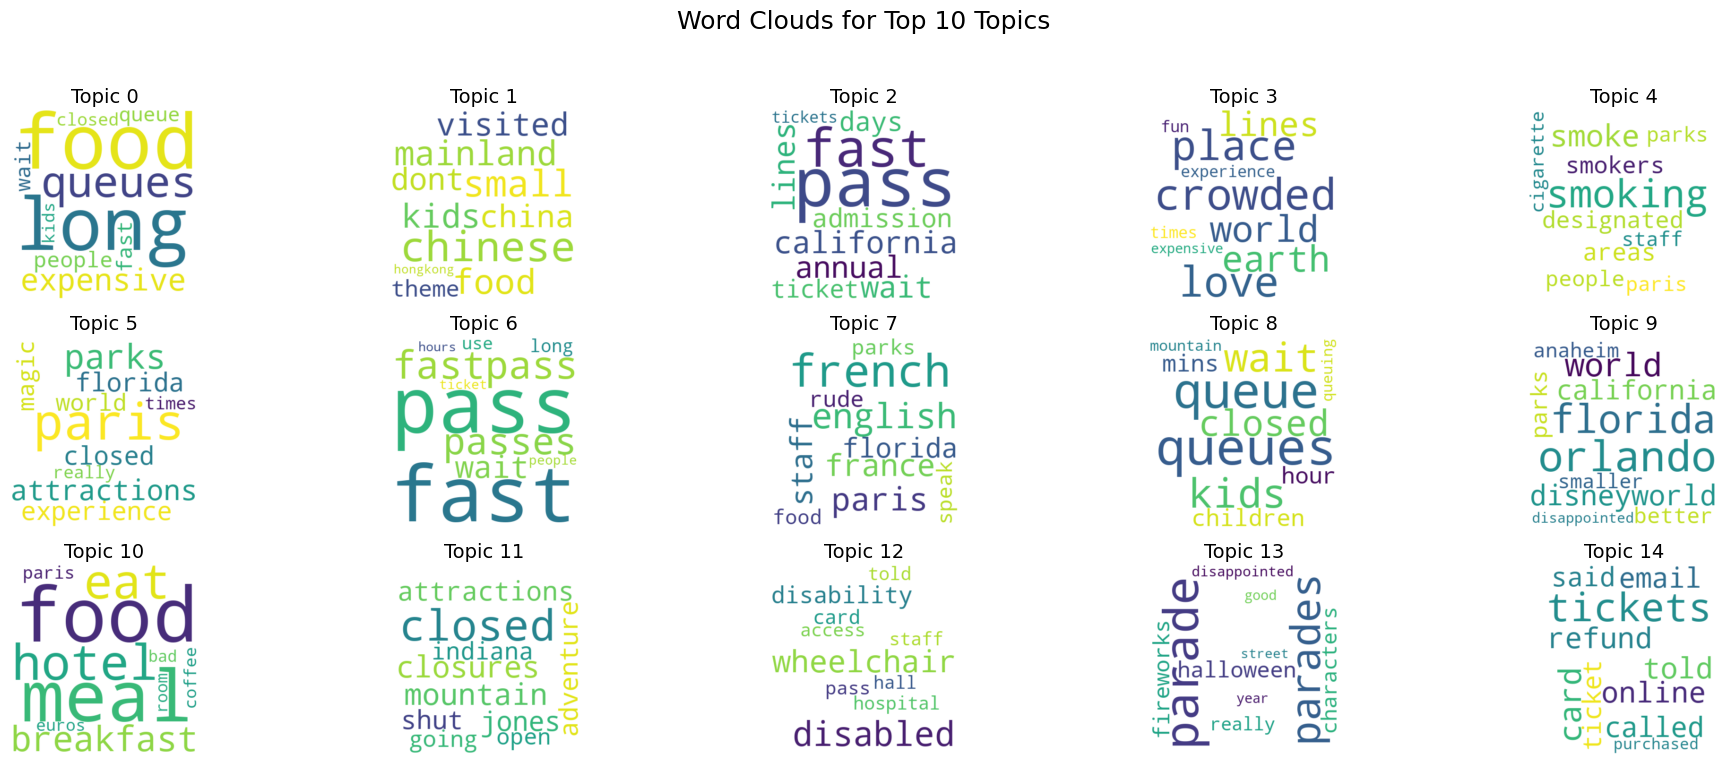

In [20]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get top 10 non-outlier topics
top_topics = topic_model.get_topic_freq().head(16)  # Includes topic -1
top_topics = top_topics[top_topics["Topic"] != -1]["Topic"].tolist()[:15]  # Top 10 topics excluding -1

# Set up plot grid (2 rows x 5 columns)
fig, axes = plt.subplots(3, 5, figsize=(20, 8))
fig.suptitle("Word Clouds for Top 10 Topics", fontsize=18)

# Flatten axes for easy iteration
axes = axes.flatten()

# Generate and plot word clouds
for idx, topic_id in enumerate(top_topics):
    topic_words = dict(topic_model.get_topic(topic_id))
    wc = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(topic_words)
    axes[idx].imshow(wc, interpolation="bilinear")
    axes[idx].axis("off")
    axes[idx].set_title(f"Topic {topic_id}", fontsize=14)

# Hide any unused subplots (if fewer than 10)
for j in range(len(top_topics), len(axes)):
    axes[j].axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit title
plt.show()

In [22]:
# Intertopic Distance Map (2D Bubble Plot)
topic_model.visualize_topics()